In [1]:
import os
import time
import datetime
import numpy as np
import warnings
import random
from PIL import Image
from tqdm import tqdm

from labels import labels

In [2]:
# 데이터 경로
#  os.getcwd() :'/home/ag/Capstone2/DeepLab_V3_ver1'
origin_data_path = os.getcwd() + '/data/Original_data/'
labeled_data_path = os.getcwd() + '/data/Labeled_data/'

origin_data_list = os.listdir(origin_data_path) # x
labeled_data_list = os.listdir(labeled_data_path) # y

# 파일명 랜덤
random.shuffle(origin_data_list)
random.shuffle(labeled_data_list)

# train, test / x, y 
train_x_file = origin_data_list[:int(len(origin_data_list)*0.8)]
train_y_file = [file_name[:-4] + '_L.png' for file_name in train_x_file]

test_x_file = [file_name for file_name in origin_data_list if file_name not in train_x_file]
test_y_file = [file_name[:-4] + '_L.png' for file_name in test_x_file]

In [3]:
print(len(train_x_file), len(test_x_file), len(train_y_file), len(test_y_file))

560 141 560 141


In [4]:
print(train_x_file[0], test_x_file[0], train_y_file[0], test_y_file[0])

Seq05VD_f02220.png 0016E5_08107.png Seq05VD_f02220_L.png 0016E5_08107_L.png


### X

In [5]:
train_x = [np.array(Image.open(origin_data_path + train)) for train in train_x_file]
test_x = [np.array(Image.open(origin_data_path + test)) for test in test_x_file]

### Y

In [6]:
# color to label catId
color2label = { label.color   : label.id for label in labels}

In [7]:
train_y = []
for file_name in tqdm(train_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    train_y.append(ret)

100%|██████████| 560/560 [21:43<00:00,  2.33s/it]


In [8]:
test_y = []
for file_name in tqdm(test_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    test_y.append(ret)

100%|██████████| 141/141 [05:28<00:00,  2.33s/it]


In [9]:
np.array(train_y).shape, np.array(test_y).shape

((560, 720, 960), (141, 720, 960))

In [10]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

### data save

In [11]:
np.savez('data.npz', train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

# Model

### package load

In [1]:
import os
import sys
import time
import datetime
from tqdm import tqdm
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms.functional as TF
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from model import convert_bn_to_instancenorm, convert_bn_to_evonorm, convert_bn_to_groupnorm, DeepLabHead, UNet
from helpers import AverageMeter, ProgressMeter, iouCalc, visim, vislbl
from labels import labels

### file name for save model log

In [3]:
filename = '07_resnet_50'

### CPU or GPU
#### 아래 코드에서 True이면 GPU 사용, False 이면 CPU 사용됨.

In [4]:
USE_CUDA = torch.cuda.is_available() and True 
device = torch.device('cuda' if USE_CUDA else 'cpu')

## data load

In [5]:
npzfile = np.load('data.npz')

train_x = npzfile['train_x']
train_y = npzfile['train_y']
test_x = npzfile['test_x']
test_y = npzfile['test_y']

npzfile.close()

In [6]:
train_x = train_x[:int(train_x.shape[0]*0.875)]
train_y = train_y[:int(train_y.shape[0]*0.875)]

val_x = train_x[int(train_x.shape[0]*0.875):]
val_y = train_y[int(train_y.shape[0]*0.875):]

In [7]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((490, 720, 960, 3), (490, 720, 960), (62, 720, 960, 3), (62, 720, 960))

### Cut Mix

In [8]:
def cutmix(image_x, image_y, size_x, size_y):
    w, h = image_x.shape[0], image_x.shape[1]
    
    # 복사할 이미지 랜덤 선택
    cxs, cys = random.randint(0, w-size_x), random.randint(0, h-size_y) # copy x start / copy y start
    cxe, cye = cxs + size_x, cys + size_y # copy x end / copy y end
    
    # 붙여넣을 위치
    xs, ys = random.randint(0, w-size_x), random.randint(0, h-size_y) 
    xe, ye = xs + size_x, ys + size_y
    
    result_x = image_x.copy()
    result_y = image_y.copy()
    result_x[xs:xe, ys:ye] = image_x[cxs:cxe, cys:cye]
    result_y[xs:xe, ys:ye] = image_y[cxs:cxe, cys:cye]
    
    return result_x, result_y

In [9]:
# cutmix_index = list(range(len(train_x)))
# np.random.shuffle(cutmix_index)

# cutmix_num = 200
# cutmix_index = cutmix_index[:cutmix_num]

# append_x = []
# append_y = []

# for i in cutmix_index:
#     app_x, app_y = cutmix(train_x[i], train_y[i], 300, 300)
#     append_x.append(app_x)
#     append_y.append(app_y)
    
# train_x = np.append(train_x, append_x, axis=0)
# train_y = np.append(train_y, append_y, axis=0)

In [9]:
train_x.shape, train_y.shape

((490, 720, 960, 3), (490, 720, 960))

### DeepLab v3 ResNet50 

In [10]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False).to(device)
model.classifier = DeepLabHead(2048, 12).to(device) # 12 = class num

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2) # 파라미터 학습속도 조절

In [12]:
# Initialize metrics
best_miou = 0.0
metrics = {'train_loss' : [],
           'train_acc' : [],
           'test_acc' : [],
           'test_loss' : [],
           'miou' : []}
start_epoch = 0

### Label 

In [13]:
# Create list of class names
classLabels = []
for label in labels:
    if label.name not in classLabels:
        classLabels.append(label.name)
classLabels.append('void')

In [14]:
validClasses = list(np.unique([label.id for label in labels if label.id >= 0] + [11]))

## train

In [15]:
train_X = torch.tensor(train_x, dtype=torch.float32)
train_Y = torch.tensor(train_y, dtype=torch.long)

train_data = torch.utils.data.TensorDataset(train_X.permute(dims=(0, 3, 1, 2)), train_Y)

train_data = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

In [16]:
# class weight

dist = {i:(train_Y == i).sum().tolist() for i in range(12)}

weights = [1/dist[i] for i in range(12)]
total_weights = sum(weights)

class_weight = torch.FloatTensor([w/total_weights for w in weights]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index=12) # weight 파라미터에 class_weight 추가

num_epoch = 100
res = train_X.shape[1] * train_X.shape[2]

In [17]:
for epoch in range(num_epoch):

    loss_running = AverageMeter('Loss', ':.4e')
    acc_running = AverageMeter('Accuracy', ':.3f')  
    iou = iouCalc(classLabels, validClasses, voidClass = 11)
    progress = ProgressMeter(
        len(train_data),
        [loss_running, acc_running],
        prefix="Train, epoch: [{}]".format(epoch))
    
    for batch, (x, y) in enumerate(tqdm(train_data, total=len(train_data))):
        
        model.train()    
    
        x = x.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(x)
        outputs = outputs['out']
        preds = torch.argmax(outputs, 1)
        
        # cross-entropy loss
        loss = criterion(outputs, y)

        # backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        bs = x.size(0)
        loss = loss.item()
        loss_running.update(loss, bs)
        corrects = torch.sum((preds == y) & (y != 12))
        
        nvoid = int((y==12).sum())
        acc = corrects.double()/(bs*res-nvoid)
        acc_running.update(acc, bs)
        
        # Calculate IoU scores of current batch
        iou.evaluateBatch(preds, y)
        
        # progress.display(batch)
        
     
    scheduler.step(loss_running.avg)
    miou = iou.outputScores()
    
    print('train epoch ', epoch+1)
    print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))
    
    # save checkpoint per epoch
    now = datetime.datetime.now()
    now_time = now.strftime('%y%m%d_%H:%M')
    
    # save path
    if not os.path.isdir(os.getcwd() + '/result/' + filename):
        os.makedirs(os.getcwd() + '/result/' + filename)
    
    save_path = os.getcwd() + '/result/' + filename + '/'
    
    with open(save_path + 'train_log_epoch.csv', 'a') as epoch_log:
            epoch_log.write('{}, {:.5f}, {:.5f}, {:.5f}\n'.format(
                    epoch+1, loss_running.avg, acc_running.avg, miou))
    
    # Save best model to file
    torch.save({
        'epoch' : epoch+1,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_miou': best_miou,
        'metrics': metrics,
        }, save_path + now_time + '_checkpoint.pth.tar')
    
    # Save best model to file
    if miou > best_miou:
        print('mIoU improved from {:.4f} to {:.4f}.'.format(best_miou, miou))
        best_miou = miou
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            }, save_path + now_time + '_best_weights.pth.tar')


100%|██████████| 245/245 [04:04<00:00,  1.00it/s]


classes           IoU
---------------------
Pole          : 0.140
SignSymbol    : 0.207
Bicyclist     : 0.220
Pedestrian    : 0.205
Building      : 0.555
Fence         : 0.289
Pavement      : 0.573
Road          : 0.833
Car           : 0.607
Sky           : 0.787
Tree          : 0.629
---------------------
Mean IoU      : 0.458
---------------------
train epoch  1
loss : 0.8931   acc : 0.7480   miou : 0.4585
mIoU improved from 0.0000 to 0.4585.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.276
SignSymbol    : 0.449
Bicyclist     : 0.593
Pedestrian    : 0.490
Building      : 0.758
Fence         : 0.555
Pavement      : 0.750
Road          : 0.923
Car           : 0.802
Sky           : 0.880
Tree          : 0.758
---------------------
Mean IoU      : 0.658
---------------------
train epoch  2
loss : 0.4433   acc : 0.8653   miou : 0.6577
mIoU improved from 0.4585 to 0.6577.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.319
SignSymbol    : 0.519
Bicyclist     : 0.652
Pedestrian    : 0.539
Building      : 0.802
Fence         : 0.652
Pavement      : 0.786
Road          : 0.936
Car           : 0.840
Sky           : 0.889
Tree          : 0.783
---------------------
Mean IoU      : 0.702
---------------------
train epoch  3
loss : 0.3554   acc : 0.8869   miou : 0.7015
mIoU improved from 0.6577 to 0.7015.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.356
SignSymbol    : 0.572
Bicyclist     : 0.698
Pedestrian    : 0.581
Building      : 0.831
Fence         : 0.701
Pavement      : 0.814
Road          : 0.945
Car           : 0.861
Sky           : 0.894
Tree          : 0.802
---------------------
Mean IoU      : 0.732
---------------------
train epoch  4
loss : 0.2986   acc : 0.9009   miou : 0.7321
mIoU improved from 0.7015 to 0.7321.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.379
SignSymbol    : 0.608
Bicyclist     : 0.720
Pedestrian    : 0.609
Building      : 0.854
Fence         : 0.757
Pavement      : 0.836
Road          : 0.952
Car           : 0.875
Sky           : 0.901
Tree          : 0.817
---------------------
Mean IoU      : 0.755
---------------------
train epoch  5
loss : 0.2575   acc : 0.9125   miou : 0.7554
mIoU improved from 0.7321 to 0.7554.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.409
SignSymbol    : 0.642
Bicyclist     : 0.731
Pedestrian    : 0.627
Building      : 0.867
Fence         : 0.777
Pavement      : 0.851
Road          : 0.959
Car           : 0.886
Sky           : 0.906
Tree          : 0.832
---------------------
Mean IoU      : 0.771
---------------------
train epoch  6
loss : 0.2293   acc : 0.9204   miou : 0.7714


  0%|          | 0/245 [00:00<?, ?it/s]

mIoU improved from 0.7554 to 0.7714.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.424
SignSymbol    : 0.666
Bicyclist     : 0.749
Pedestrian    : 0.637
Building      : 0.876
Fence         : 0.804
Pavement      : 0.863
Road          : 0.961
Car           : 0.892
Sky           : 0.908
Tree          : 0.842
---------------------
Mean IoU      : 0.784
---------------------
train epoch  7
loss : 0.2100   acc : 0.9256   miou : 0.7839
mIoU improved from 0.7714 to 0.7839.


100%|██████████| 245/245 [04:06<00:00,  1.01s/it]


classes           IoU
---------------------
Pole          : 0.441
SignSymbol    : 0.681
Bicyclist     : 0.758
Pedestrian    : 0.656
Building      : 0.885
Fence         : 0.815
Pavement      : 0.871
Road          : 0.965
Car           : 0.897
Sky           : 0.911
Tree          : 0.850
---------------------
Mean IoU      : 0.794
---------------------
train epoch  8
loss : 0.1953   acc : 0.9302   miou : 0.7936
mIoU improved from 0.7839 to 0.7936.


100%|██████████| 245/245 [04:06<00:00,  1.01s/it]


classes           IoU
---------------------
Pole          : 0.456
SignSymbol    : 0.696
Bicyclist     : 0.768
Pedestrian    : 0.668
Building      : 0.891
Fence         : 0.831
Pavement      : 0.877
Road          : 0.967
Car           : 0.903
Sky           : 0.913
Tree          : 0.854
---------------------
Mean IoU      : 0.802
---------------------
train epoch  9
loss : 0.1823   acc : 0.9335   miou : 0.8023
mIoU improved from 0.7936 to 0.8023.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.469
SignSymbol    : 0.715
Bicyclist     : 0.778
Pedestrian    : 0.679
Building      : 0.897
Fence         : 0.840
Pavement      : 0.884
Road          : 0.968
Car           : 0.907
Sky           : 0.915
Tree          : 0.862
---------------------
Mean IoU      : 0.810
---------------------
train epoch  10
loss : 0.1723   acc : 0.9367   miou : 0.8103
mIoU improved from 0.8023 to 0.8103.


100%|██████████| 245/245 [04:06<00:00,  1.01s/it]


classes           IoU
---------------------
Pole          : 0.480
SignSymbol    : 0.722
Bicyclist     : 0.784
Pedestrian    : 0.688
Building      : 0.901
Fence         : 0.849
Pavement      : 0.885
Road          : 0.969
Car           : 0.910
Sky           : 0.917
Tree          : 0.866
---------------------
Mean IoU      : 0.816
---------------------
train epoch  11
loss : 0.1645   acc : 0.9390   miou : 0.8157


  0%|          | 0/245 [00:00<?, ?it/s]

mIoU improved from 0.8103 to 0.8157.


100%|██████████| 245/245 [04:06<00:00,  1.01s/it]


classes           IoU
---------------------
Pole          : 0.488
SignSymbol    : 0.732
Bicyclist     : 0.790
Pedestrian    : 0.696
Building      : 0.905
Fence         : 0.851
Pavement      : 0.891
Road          : 0.970
Car           : 0.913
Sky           : 0.918
Tree          : 0.870
---------------------
Mean IoU      : 0.820
---------------------
train epoch  12
loss : 0.1588   acc : 0.9408   miou : 0.8203
mIoU improved from 0.8157 to 0.8203.


100%|██████████| 245/245 [04:06<00:00,  1.01s/it]


classes           IoU
---------------------
Pole          : 0.497
SignSymbol    : 0.744
Bicyclist     : 0.797
Pedestrian    : 0.704
Building      : 0.909
Fence         : 0.860
Pavement      : 0.894
Road          : 0.971
Car           : 0.915
Sky           : 0.918
Tree          : 0.873
---------------------
Mean IoU      : 0.826
---------------------
train epoch  13
loss : 0.1522   acc : 0.9426   miou : 0.8255
mIoU improved from 0.8203 to 0.8255.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.505
SignSymbol    : 0.745
Bicyclist     : 0.803
Pedestrian    : 0.711
Building      : 0.911
Fence         : 0.864
Pavement      : 0.899
Road          : 0.973
Car           : 0.917
Sky           : 0.919
Tree          : 0.876
---------------------
Mean IoU      : 0.829
---------------------
train epoch  14
loss : 0.1468   acc : 0.9442   miou : 0.8294
mIoU improved from 0.8255 to 0.8294.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.513
SignSymbol    : 0.756
Bicyclist     : 0.805
Pedestrian    : 0.711
Building      : 0.915
Fence         : 0.871
Pavement      : 0.901
Road          : 0.973
Car           : 0.919
Sky           : 0.921
Tree          : 0.879
---------------------
Mean IoU      : 0.833
---------------------
train epoch  15
loss : 0.1418   acc : 0.9457   miou : 0.8332
mIoU improved from 0.8294 to 0.8332.


100%|██████████| 245/245 [04:06<00:00,  1.01s/it]


classes           IoU
---------------------
Pole          : 0.520
SignSymbol    : 0.761
Bicyclist     : 0.813
Pedestrian    : 0.718
Building      : 0.917
Fence         : 0.876
Pavement      : 0.904
Road          : 0.974
Car           : 0.922
Sky           : 0.923
Tree          : 0.883
---------------------
Mean IoU      : 0.837
---------------------
train epoch  16
loss : 0.1363   acc : 0.9474   miou : 0.8374
mIoU improved from 0.8332 to 0.8374.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.524
SignSymbol    : 0.770
Bicyclist     : 0.812
Pedestrian    : 0.727
Building      : 0.920
Fence         : 0.880
Pavement      : 0.906
Road          : 0.975
Car           : 0.924
Sky           : 0.922
Tree          : 0.886
---------------------
Mean IoU      : 0.841
---------------------
train epoch  17
loss : 0.1329   acc : 0.9486   miou : 0.8405
mIoU improved from 0.8374 to 0.8405.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.531
SignSymbol    : 0.771
Bicyclist     : 0.814
Pedestrian    : 0.731
Building      : 0.921
Fence         : 0.884
Pavement      : 0.908
Road          : 0.975
Car           : 0.925
Sky           : 0.924
Tree          : 0.887
---------------------
Mean IoU      : 0.843
---------------------
train epoch  18
loss : 0.1311   acc : 0.9494   miou : 0.8427
mIoU improved from 0.8405 to 0.8427.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.537
SignSymbol    : 0.775
Bicyclist     : 0.819
Pedestrian    : 0.736
Building      : 0.923
Fence         : 0.885
Pavement      : 0.909
Road          : 0.975
Car           : 0.927
Sky           : 0.924
Tree          : 0.890
---------------------
Mean IoU      : 0.845
---------------------
train epoch  19
loss : 0.1282   acc : 0.9501   miou : 0.8453
mIoU improved from 0.8427 to 0.8453.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.542
SignSymbol    : 0.782
Bicyclist     : 0.824
Pedestrian    : 0.735
Building      : 0.924
Fence         : 0.888
Pavement      : 0.911
Road          : 0.976
Car           : 0.928
Sky           : 0.925
Tree          : 0.890
---------------------
Mean IoU      : 0.848
---------------------
train epoch  20
loss : 0.1256   acc : 0.9509   miou : 0.8478
mIoU improved from 0.8453 to 0.8478.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.546
SignSymbol    : 0.785
Bicyclist     : 0.824
Pedestrian    : 0.742
Building      : 0.926
Fence         : 0.892
Pavement      : 0.913
Road          : 0.976
Car           : 0.930
Sky           : 0.925
Tree          : 0.891
---------------------
Mean IoU      : 0.850
---------------------
train epoch  21
loss : 0.1218   acc : 0.9518   miou : 0.8499
mIoU improved from 0.8478 to 0.8499.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.550
SignSymbol    : 0.788
Bicyclist     : 0.827
Pedestrian    : 0.743
Building      : 0.927
Fence         : 0.894
Pavement      : 0.915
Road          : 0.977
Car           : 0.931
Sky           : 0.926
Tree          : 0.894
---------------------
Mean IoU      : 0.852
---------------------
train epoch  22
loss : 0.1195   acc : 0.9527   miou : 0.8519
mIoU improved from 0.8499 to 0.8519.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.555
SignSymbol    : 0.794
Bicyclist     : 0.832
Pedestrian    : 0.748
Building      : 0.929
Fence         : 0.896
Pavement      : 0.917
Road          : 0.977
Car           : 0.932
Sky           : 0.926
Tree          : 0.896
---------------------
Mean IoU      : 0.855
---------------------
train epoch  23
loss : 0.1171   acc : 0.9536   miou : 0.8548
mIoU improved from 0.8519 to 0.8548.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.559
SignSymbol    : 0.799
Bicyclist     : 0.834
Pedestrian    : 0.751
Building      : 0.930
Fence         : 0.899
Pavement      : 0.917
Road          : 0.977
Car           : 0.933
Sky           : 0.927
Tree          : 0.897
---------------------
Mean IoU      : 0.857
---------------------
train epoch  24
loss : 0.1152   acc : 0.9543   miou : 0.8567
mIoU improved from 0.8548 to 0.8567.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.561
SignSymbol    : 0.801
Bicyclist     : 0.833
Pedestrian    : 0.752
Building      : 0.931
Fence         : 0.900
Pavement      : 0.920
Road          : 0.978
Car           : 0.934
Sky           : 0.928
Tree          : 0.899
---------------------
Mean IoU      : 0.858
---------------------
train epoch  25
loss : 0.1132   acc : 0.9550   miou : 0.8580
mIoU improved from 0.8567 to 0.8580.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.564
SignSymbol    : 0.805
Bicyclist     : 0.836
Pedestrian    : 0.753
Building      : 0.932
Fence         : 0.902
Pavement      : 0.920
Road          : 0.978
Car           : 0.933
Sky           : 0.928
Tree          : 0.900
---------------------
Mean IoU      : 0.859
---------------------
train epoch  26
loss : 0.1126   acc : 0.9551   miou : 0.8591
mIoU improved from 0.8580 to 0.8591.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.567
SignSymbol    : 0.805
Bicyclist     : 0.837
Pedestrian    : 0.758
Building      : 0.932
Fence         : 0.901
Pavement      : 0.920
Road          : 0.978
Car           : 0.935
Sky           : 0.927
Tree          : 0.901
---------------------
Mean IoU      : 0.860
---------------------
train epoch  27
loss : 0.1118   acc : 0.9554   miou : 0.8601
mIoU improved from 0.8591 to 0.8601.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.571
SignSymbol    : 0.809
Bicyclist     : 0.839
Pedestrian    : 0.759
Building      : 0.933
Fence         : 0.900
Pavement      : 0.922
Road          : 0.979
Car           : 0.935
Sky           : 0.928
Tree          : 0.902
---------------------
Mean IoU      : 0.861
---------------------
train epoch  28
loss : 0.1099   acc : 0.9560   miou : 0.8614
mIoU improved from 0.8601 to 0.8614.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.577
SignSymbol    : 0.811
Bicyclist     : 0.842
Pedestrian    : 0.763
Building      : 0.935
Fence         : 0.905
Pavement      : 0.924
Road          : 0.979
Car           : 0.937
Sky           : 0.928
Tree          : 0.904
---------------------
Mean IoU      : 0.864
---------------------
train epoch  29
loss : 0.1074   acc : 0.9569   miou : 0.8641
mIoU improved from 0.8614 to 0.8641.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.578
SignSymbol    : 0.814
Bicyclist     : 0.843
Pedestrian    : 0.764
Building      : 0.936
Fence         : 0.907
Pavement      : 0.925
Road          : 0.979
Car           : 0.938
Sky           : 0.930
Tree          : 0.904
---------------------
Mean IoU      : 0.865
---------------------
train epoch  30
loss : 0.1056   acc : 0.9574   miou : 0.8652
mIoU improved from 0.8641 to 0.8652.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.581
SignSymbol    : 0.817
Bicyclist     : 0.845
Pedestrian    : 0.766
Building      : 0.937
Fence         : 0.911
Pavement      : 0.925
Road          : 0.979
Car           : 0.938
Sky           : 0.930
Tree          : 0.905
---------------------
Mean IoU      : 0.867
---------------------
train epoch  31
loss : 0.1043   acc : 0.9578   miou : 0.8667
mIoU improved from 0.8652 to 0.8667.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.584
SignSymbol    : 0.818
Bicyclist     : 0.847
Pedestrian    : 0.768
Building      : 0.938
Fence         : 0.910
Pavement      : 0.926
Road          : 0.979
Car           : 0.939
Sky           : 0.930
Tree          : 0.907
---------------------
Mean IoU      : 0.868
---------------------
train epoch  32
loss : 0.1034   acc : 0.9582   miou : 0.8678
mIoU improved from 0.8667 to 0.8678.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.586
SignSymbol    : 0.822
Bicyclist     : 0.849
Pedestrian    : 0.772
Building      : 0.939
Fence         : 0.913
Pavement      : 0.928
Road          : 0.980
Car           : 0.939
Sky           : 0.930
Tree          : 0.908
---------------------
Mean IoU      : 0.870
---------------------
train epoch  33
loss : 0.1011   acc : 0.9589   miou : 0.8696
mIoU improved from 0.8678 to 0.8696.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.590
SignSymbol    : 0.823
Bicyclist     : 0.847
Pedestrian    : 0.773
Building      : 0.940
Fence         : 0.914
Pavement      : 0.929
Road          : 0.980
Car           : 0.941
Sky           : 0.931
Tree          : 0.909
---------------------
Mean IoU      : 0.871
---------------------
train epoch  34
loss : 0.1001   acc : 0.9594   miou : 0.8706
mIoU improved from 0.8696 to 0.8706.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.592
SignSymbol    : 0.825
Bicyclist     : 0.849
Pedestrian    : 0.775
Building      : 0.940
Fence         : 0.916
Pavement      : 0.929
Road          : 0.980
Car           : 0.941
Sky           : 0.931
Tree          : 0.910
---------------------
Mean IoU      : 0.872
---------------------
train epoch  35
loss : 0.0998   acc : 0.9596   miou : 0.8715
mIoU improved from 0.8706 to 0.8715.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.593
SignSymbol    : 0.826
Bicyclist     : 0.850
Pedestrian    : 0.778
Building      : 0.941
Fence         : 0.916
Pavement      : 0.930
Road          : 0.980
Car           : 0.942
Sky           : 0.931
Tree          : 0.910
---------------------
Mean IoU      : 0.872
---------------------
train epoch  36
loss : 0.0987   acc : 0.9599   miou : 0.8724
mIoU improved from 0.8715 to 0.8724.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.596
SignSymbol    : 0.827
Bicyclist     : 0.853
Pedestrian    : 0.777
Building      : 0.942
Fence         : 0.916
Pavement      : 0.931
Road          : 0.981
Car           : 0.942
Sky           : 0.931
Tree          : 0.911
---------------------
Mean IoU      : 0.873
---------------------
train epoch  37
loss : 0.0976   acc : 0.9604   miou : 0.8733
mIoU improved from 0.8724 to 0.8733.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.598
SignSymbol    : 0.831
Bicyclist     : 0.852
Pedestrian    : 0.778
Building      : 0.942
Fence         : 0.916
Pavement      : 0.932
Road          : 0.981
Car           : 0.942
Sky           : 0.931
Tree          : 0.912
---------------------
Mean IoU      : 0.874
---------------------
train epoch  38
loss : 0.0967   acc : 0.9606   miou : 0.8742
mIoU improved from 0.8733 to 0.8742.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.601
SignSymbol    : 0.833
Bicyclist     : 0.854
Pedestrian    : 0.781
Building      : 0.943
Fence         : 0.916
Pavement      : 0.933
Road          : 0.981
Car           : 0.943
Sky           : 0.932
Tree          : 0.913
---------------------
Mean IoU      : 0.875
---------------------
train epoch  39
loss : 0.0954   acc : 0.9610   miou : 0.8754
mIoU improved from 0.8742 to 0.8754.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.603
SignSymbol    : 0.833
Bicyclist     : 0.856
Pedestrian    : 0.782
Building      : 0.943
Fence         : 0.920
Pavement      : 0.933
Road          : 0.981
Car           : 0.944
Sky           : 0.932
Tree          : 0.914
---------------------
Mean IoU      : 0.876
---------------------
train epoch  40
loss : 0.0938   acc : 0.9613   miou : 0.8764
mIoU improved from 0.8754 to 0.8764.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.605
SignSymbol    : 0.836
Bicyclist     : 0.857
Pedestrian    : 0.784
Building      : 0.944
Fence         : 0.920
Pavement      : 0.933
Road          : 0.981
Car           : 0.945
Sky           : 0.932
Tree          : 0.914
---------------------
Mean IoU      : 0.877
---------------------
train epoch  41
loss : 0.0936   acc : 0.9615   miou : 0.8774
mIoU improved from 0.8764 to 0.8774.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.607
SignSymbol    : 0.838
Bicyclist     : 0.859
Pedestrian    : 0.786
Building      : 0.945
Fence         : 0.921
Pavement      : 0.934
Road          : 0.981
Car           : 0.945
Sky           : 0.933
Tree          : 0.915
---------------------
Mean IoU      : 0.878
---------------------
train epoch  42
loss : 0.0925   acc : 0.9619   miou : 0.8785
mIoU improved from 0.8774 to 0.8785.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.610
SignSymbol    : 0.840
Bicyclist     : 0.858
Pedestrian    : 0.786
Building      : 0.945
Fence         : 0.923
Pavement      : 0.935
Road          : 0.982
Car           : 0.945
Sky           : 0.933
Tree          : 0.915
---------------------
Mean IoU      : 0.879
---------------------
train epoch  43
loss : 0.0919   acc : 0.9622   miou : 0.8793
mIoU improved from 0.8785 to 0.8793.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.609
SignSymbol    : 0.840
Bicyclist     : 0.861
Pedestrian    : 0.787
Building      : 0.945
Fence         : 0.921
Pavement      : 0.935
Road          : 0.982
Car           : 0.945
Sky           : 0.933
Tree          : 0.916
---------------------
Mean IoU      : 0.879
---------------------
train epoch  44
loss : 0.0911   acc : 0.9624   miou : 0.8795
mIoU improved from 0.8793 to 0.8795.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.613
SignSymbol    : 0.841
Bicyclist     : 0.861
Pedestrian    : 0.789
Building      : 0.946
Fence         : 0.925
Pavement      : 0.935
Road          : 0.982
Car           : 0.946
Sky           : 0.934
Tree          : 0.917
---------------------
Mean IoU      : 0.881
---------------------
train epoch  45
loss : 0.0904   acc : 0.9627   miou : 0.8807


  0%|          | 0/245 [00:00<?, ?it/s]

mIoU improved from 0.8795 to 0.8807.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.614
SignSymbol    : 0.844
Bicyclist     : 0.862
Pedestrian    : 0.792
Building      : 0.947
Fence         : 0.925
Pavement      : 0.936
Road          : 0.982
Car           : 0.947
Sky           : 0.933
Tree          : 0.918
---------------------
Mean IoU      : 0.882
---------------------
train epoch  46
loss : 0.0891   acc : 0.9631   miou : 0.8819


  0%|          | 0/245 [00:00<?, ?it/s]

mIoU improved from 0.8807 to 0.8819.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.616
SignSymbol    : 0.846
Bicyclist     : 0.862
Pedestrian    : 0.793
Building      : 0.947
Fence         : 0.927
Pavement      : 0.938
Road          : 0.982
Car           : 0.947
Sky           : 0.934
Tree          : 0.919
---------------------
Mean IoU      : 0.883
---------------------
train epoch  47
loss : 0.0882   acc : 0.9634   miou : 0.8828
mIoU improved from 0.8819 to 0.8828.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.616
SignSymbol    : 0.845
Bicyclist     : 0.862
Pedestrian    : 0.793
Building      : 0.948
Fence         : 0.928
Pavement      : 0.937
Road          : 0.982
Car           : 0.947
Sky           : 0.934
Tree          : 0.919
---------------------
Mean IoU      : 0.883
---------------------
train epoch  48
loss : 0.0879   acc : 0.9635   miou : 0.8828
mIoU improved from 0.8828 to 0.8828.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.620
SignSymbol    : 0.848
Bicyclist     : 0.863
Pedestrian    : 0.795
Building      : 0.948
Fence         : 0.929
Pavement      : 0.938
Road          : 0.982
Car           : 0.948
Sky           : 0.934
Tree          : 0.920
---------------------
Mean IoU      : 0.884
---------------------
train epoch  49
loss : 0.0873   acc : 0.9639   miou : 0.8841
mIoU improved from 0.8828 to 0.8841.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.621
SignSymbol    : 0.849
Bicyclist     : 0.865
Pedestrian    : 0.796
Building      : 0.949
Fence         : 0.928
Pavement      : 0.938
Road          : 0.982
Car           : 0.948
Sky           : 0.935
Tree          : 0.920
---------------------
Mean IoU      : 0.884
---------------------
train epoch  50
loss : 0.0869   acc : 0.9640   miou : 0.8844
mIoU improved from 0.8841 to 0.8844.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.622
SignSymbol    : 0.849
Bicyclist     : 0.866
Pedestrian    : 0.795
Building      : 0.949
Fence         : 0.929
Pavement      : 0.939
Road          : 0.982
Car           : 0.948
Sky           : 0.934
Tree          : 0.920
---------------------
Mean IoU      : 0.885
---------------------
train epoch  51
loss : 0.0864   acc : 0.9641   miou : 0.8849
mIoU improved from 0.8844 to 0.8849.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.623
SignSymbol    : 0.851
Bicyclist     : 0.866
Pedestrian    : 0.798
Building      : 0.949
Fence         : 0.929
Pavement      : 0.940
Road          : 0.983
Car           : 0.948
Sky           : 0.935
Tree          : 0.920
---------------------
Mean IoU      : 0.886
---------------------
train epoch  52
loss : 0.0856   acc : 0.9643   miou : 0.8855
mIoU improved from 0.8849 to 0.8855.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.624
SignSymbol    : 0.850
Bicyclist     : 0.868
Pedestrian    : 0.799
Building      : 0.949
Fence         : 0.930
Pavement      : 0.940
Road          : 0.983
Car           : 0.949
Sky           : 0.935
Tree          : 0.921
---------------------
Mean IoU      : 0.886
---------------------
train epoch  53
loss : 0.0854   acc : 0.9644   miou : 0.8861
mIoU improved from 0.8855 to 0.8861.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.626
SignSymbol    : 0.852
Bicyclist     : 0.867
Pedestrian    : 0.798
Building      : 0.949
Fence         : 0.930
Pavement      : 0.939
Road          : 0.983
Car           : 0.950
Sky           : 0.935
Tree          : 0.921
---------------------
Mean IoU      : 0.886
---------------------
train epoch  54
loss : 0.0851   acc : 0.9645   miou : 0.8863
mIoU improved from 0.8861 to 0.8863.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.628
SignSymbol    : 0.854
Bicyclist     : 0.868
Pedestrian    : 0.799
Building      : 0.950
Fence         : 0.931
Pavement      : 0.941
Road          : 0.983
Car           : 0.950
Sky           : 0.935
Tree          : 0.922
---------------------
Mean IoU      : 0.888
---------------------
train epoch  55
loss : 0.0836   acc : 0.9650   miou : 0.8875
mIoU improved from 0.8863 to 0.8875.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.628
SignSymbol    : 0.854
Bicyclist     : 0.870
Pedestrian    : 0.803
Building      : 0.951
Fence         : 0.931
Pavement      : 0.941
Road          : 0.983
Car           : 0.950
Sky           : 0.935
Tree          : 0.923
---------------------
Mean IoU      : 0.888
---------------------
train epoch  56
loss : 0.0835   acc : 0.9652   miou : 0.8881
mIoU improved from 0.8875 to 0.8881.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.629
SignSymbol    : 0.855
Bicyclist     : 0.871
Pedestrian    : 0.802
Building      : 0.951
Fence         : 0.932
Pavement      : 0.941
Road          : 0.983
Car           : 0.951
Sky           : 0.935
Tree          : 0.923
---------------------
Mean IoU      : 0.888
---------------------
train epoch  57
loss : 0.0827   acc : 0.9653   miou : 0.8885
mIoU improved from 0.8881 to 0.8885.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.632
SignSymbol    : 0.857
Bicyclist     : 0.872
Pedestrian    : 0.804
Building      : 0.951
Fence         : 0.932
Pavement      : 0.942
Road          : 0.983
Car           : 0.951
Sky           : 0.936
Tree          : 0.923
---------------------
Mean IoU      : 0.889
---------------------
train epoch  58
loss : 0.0823   acc : 0.9655   miou : 0.8892
mIoU improved from 0.8885 to 0.8892.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.633
SignSymbol    : 0.858
Bicyclist     : 0.872
Pedestrian    : 0.804
Building      : 0.952
Fence         : 0.933
Pavement      : 0.942
Road          : 0.983
Car           : 0.952
Sky           : 0.936
Tree          : 0.924
---------------------
Mean IoU      : 0.890
---------------------
train epoch  59
loss : 0.0821   acc : 0.9657   miou : 0.8898
mIoU improved from 0.8892 to 0.8898.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.634
SignSymbol    : 0.860
Bicyclist     : 0.872
Pedestrian    : 0.805
Building      : 0.952
Fence         : 0.932
Pavement      : 0.943
Road          : 0.984
Car           : 0.952
Sky           : 0.936
Tree          : 0.924
---------------------
Mean IoU      : 0.890
---------------------
train epoch  60
loss : 0.0812   acc : 0.9659   miou : 0.8902
mIoU improved from 0.8898 to 0.8902.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.636
SignSymbol    : 0.860
Bicyclist     : 0.873
Pedestrian    : 0.806
Building      : 0.952
Fence         : 0.934
Pavement      : 0.943
Road          : 0.983
Car           : 0.952
Sky           : 0.936
Tree          : 0.925
---------------------
Mean IoU      : 0.891
---------------------
train epoch  61
loss : 0.0810   acc : 0.9661   miou : 0.8909
mIoU improved from 0.8902 to 0.8909.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.636
SignSymbol    : 0.861
Bicyclist     : 0.874
Pedestrian    : 0.807
Building      : 0.953
Fence         : 0.935
Pavement      : 0.944
Road          : 0.984
Car           : 0.952
Sky           : 0.936
Tree          : 0.925
---------------------
Mean IoU      : 0.892
---------------------
train epoch  62
loss : 0.0802   acc : 0.9663   miou : 0.8915


  0%|          | 0/245 [00:00<?, ?it/s]

mIoU improved from 0.8909 to 0.8915.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.637
SignSymbol    : 0.861
Bicyclist     : 0.874
Pedestrian    : 0.808
Building      : 0.953
Fence         : 0.936
Pavement      : 0.944
Road          : 0.984
Car           : 0.953
Sky           : 0.936
Tree          : 0.925
---------------------
Mean IoU      : 0.892
---------------------
train epoch  63
loss : 0.0795   acc : 0.9665   miou : 0.8920
mIoU improved from 0.8915 to 0.8920.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.638
SignSymbol    : 0.862
Bicyclist     : 0.875
Pedestrian    : 0.809
Building      : 0.953
Fence         : 0.934
Pavement      : 0.944
Road          : 0.984
Car           : 0.953
Sky           : 0.936
Tree          : 0.926
---------------------
Mean IoU      : 0.892
---------------------
train epoch  64
loss : 0.0793   acc : 0.9666   miou : 0.8924
mIoU improved from 0.8920 to 0.8924.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.639
SignSymbol    : 0.864
Bicyclist     : 0.875
Pedestrian    : 0.809
Building      : 0.953
Fence         : 0.936
Pavement      : 0.945
Road          : 0.984
Car           : 0.953
Sky           : 0.937
Tree          : 0.926
---------------------
Mean IoU      : 0.893
---------------------
train epoch  65
loss : 0.0792   acc : 0.9668   miou : 0.8928
mIoU improved from 0.8924 to 0.8928.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.640
SignSymbol    : 0.863
Bicyclist     : 0.876
Pedestrian    : 0.811
Building      : 0.954
Fence         : 0.937
Pavement      : 0.945
Road          : 0.984
Car           : 0.953
Sky           : 0.936
Tree          : 0.927
---------------------
Mean IoU      : 0.893
---------------------
train epoch  66
loss : 0.0789   acc : 0.9668   miou : 0.8933
mIoU improved from 0.8928 to 0.8933.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.640
SignSymbol    : 0.864
Bicyclist     : 0.877
Pedestrian    : 0.811
Building      : 0.954
Fence         : 0.937
Pavement      : 0.945
Road          : 0.984
Car           : 0.953
Sky           : 0.936
Tree          : 0.926
---------------------
Mean IoU      : 0.893
---------------------
train epoch  67
loss : 0.0789   acc : 0.9667   miou : 0.8934
mIoU improved from 0.8933 to 0.8934.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.641
SignSymbol    : 0.865
Bicyclist     : 0.877
Pedestrian    : 0.810
Building      : 0.954
Fence         : 0.937
Pavement      : 0.945
Road          : 0.984
Car           : 0.953
Sky           : 0.937
Tree          : 0.926
---------------------
Mean IoU      : 0.894
---------------------
train epoch  68
loss : 0.0786   acc : 0.9669   miou : 0.8937
mIoU improved from 0.8934 to 0.8937.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.643
SignSymbol    : 0.867
Bicyclist     : 0.879
Pedestrian    : 0.812
Building      : 0.955
Fence         : 0.938
Pavement      : 0.946
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.927
---------------------
Mean IoU      : 0.895
---------------------
train epoch  69
loss : 0.0773   acc : 0.9672   miou : 0.8947
mIoU improved from 0.8937 to 0.8947.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.644
SignSymbol    : 0.868
Bicyclist     : 0.880
Pedestrian    : 0.813
Building      : 0.955
Fence         : 0.937
Pavement      : 0.946
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.928
---------------------
Mean IoU      : 0.895
---------------------
train epoch  70
loss : 0.0771   acc : 0.9674   miou : 0.8950
mIoU improved from 0.8947 to 0.8950.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.646
SignSymbol    : 0.868
Bicyclist     : 0.879
Pedestrian    : 0.813
Building      : 0.955
Fence         : 0.939
Pavement      : 0.946
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.928
---------------------
Mean IoU      : 0.895
---------------------
train epoch  71
loss : 0.0768   acc : 0.9676   miou : 0.8954
mIoU improved from 0.8950 to 0.8954.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.646
SignSymbol    : 0.868
Bicyclist     : 0.880
Pedestrian    : 0.814
Building      : 0.955
Fence         : 0.939
Pavement      : 0.946
Road          : 0.984
Car           : 0.955
Sky           : 0.937
Tree          : 0.928
---------------------
Mean IoU      : 0.896
---------------------
train epoch  72
loss : 0.0762   acc : 0.9676   miou : 0.8958
mIoU improved from 0.8954 to 0.8958.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.647
SignSymbol    : 0.869
Bicyclist     : 0.881
Pedestrian    : 0.815
Building      : 0.955
Fence         : 0.939
Pavement      : 0.947
Road          : 0.985
Car           : 0.955
Sky           : 0.937
Tree          : 0.928
---------------------
Mean IoU      : 0.896
---------------------
train epoch  73
loss : 0.0764   acc : 0.9677   miou : 0.8962
mIoU improved from 0.8958 to 0.8962.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.649
SignSymbol    : 0.869
Bicyclist     : 0.882
Pedestrian    : 0.816
Building      : 0.956
Fence         : 0.938
Pavement      : 0.947
Road          : 0.985
Car           : 0.955
Sky           : 0.937
Tree          : 0.929
---------------------
Mean IoU      : 0.896
---------------------
train epoch  74
loss : 0.0758   acc : 0.9679   miou : 0.8965
mIoU improved from 0.8962 to 0.8965.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.648
SignSymbol    : 0.870
Bicyclist     : 0.881
Pedestrian    : 0.816
Building      : 0.956
Fence         : 0.940
Pavement      : 0.947
Road          : 0.984
Car           : 0.955
Sky           : 0.937
Tree          : 0.929
---------------------
Mean IoU      : 0.897
---------------------
train epoch  75
loss : 0.0755   acc : 0.9679   miou : 0.8967
mIoU improved from 0.8965 to 0.8967.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.650
SignSymbol    : 0.871
Bicyclist     : 0.882
Pedestrian    : 0.816
Building      : 0.956
Fence         : 0.940
Pavement      : 0.948
Road          : 0.985
Car           : 0.956
Sky           : 0.938
Tree          : 0.929
---------------------
Mean IoU      : 0.897
---------------------
train epoch  76
loss : 0.0749   acc : 0.9682   miou : 0.8973
mIoU improved from 0.8967 to 0.8973.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.651
SignSymbol    : 0.872
Bicyclist     : 0.883
Pedestrian    : 0.817
Building      : 0.957
Fence         : 0.940
Pavement      : 0.948
Road          : 0.985
Car           : 0.956
Sky           : 0.938
Tree          : 0.930
---------------------
Mean IoU      : 0.898
---------------------
train epoch  77
loss : 0.0746   acc : 0.9684   miou : 0.8979
mIoU improved from 0.8973 to 0.8979.


  0%|          | 0/245 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.651
SignSymbol    : 0.872
Bicyclist     : 0.881
Pedestrian    : 0.818
Building      : 0.956
Fence         : 0.941
Pavement      : 0.948
Road          : 0.985
Car           : 0.956
Sky           : 0.938
Tree          : 0.930
---------------------
Mean IoU      : 0.898
---------------------
train epoch  78
loss : 0.0747   acc : 0.9684   miou : 0.8978


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.653
SignSymbol    : 0.873
Bicyclist     : 0.884
Pedestrian    : 0.819
Building      : 0.957
Fence         : 0.941
Pavement      : 0.948
Road          : 0.985
Car           : 0.956
Sky           : 0.938
Tree          : 0.930
---------------------
Mean IoU      : 0.899
---------------------
train epoch  79
loss : 0.0738   acc : 0.9685   miou : 0.8986
mIoU improved from 0.8979 to 0.8986.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.654
SignSymbol    : 0.873
Bicyclist     : 0.884
Pedestrian    : 0.820
Building      : 0.957
Fence         : 0.942
Pavement      : 0.949
Road          : 0.985
Car           : 0.957
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.899
---------------------
train epoch  80
loss : 0.0738   acc : 0.9687   miou : 0.8989
mIoU improved from 0.8986 to 0.8989.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.654
SignSymbol    : 0.873
Bicyclist     : 0.884
Pedestrian    : 0.820
Building      : 0.957
Fence         : 0.942
Pavement      : 0.949
Road          : 0.985
Car           : 0.957
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.899
---------------------
train epoch  81
loss : 0.0735   acc : 0.9687   miou : 0.8990
mIoU improved from 0.8989 to 0.8990.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.656
SignSymbol    : 0.874
Bicyclist     : 0.884
Pedestrian    : 0.820
Building      : 0.957
Fence         : 0.941
Pavement      : 0.949
Road          : 0.985
Car           : 0.957
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.899
---------------------
train epoch  82
loss : 0.0733   acc : 0.9687   miou : 0.8993
mIoU improved from 0.8990 to 0.8993.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.656
SignSymbol    : 0.876
Bicyclist     : 0.885
Pedestrian    : 0.821
Building      : 0.958
Fence         : 0.942
Pavement      : 0.950
Road          : 0.985
Car           : 0.957
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.900
---------------------
train epoch  83
loss : 0.0731   acc : 0.9690   miou : 0.8999
mIoU improved from 0.8993 to 0.8999.


  0%|          | 0/245 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.656
SignSymbol    : 0.875
Bicyclist     : 0.886
Pedestrian    : 0.821
Building      : 0.957
Fence         : 0.942
Pavement      : 0.950
Road          : 0.985
Car           : 0.957
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.900
---------------------
train epoch  84
loss : 0.0726   acc : 0.9690   miou : 0.8999


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.657
SignSymbol    : 0.877
Bicyclist     : 0.886
Pedestrian    : 0.822
Building      : 0.958
Fence         : 0.943
Pavement      : 0.950
Road          : 0.985
Car           : 0.958
Sky           : 0.938
Tree          : 0.932
---------------------
Mean IoU      : 0.901
---------------------
train epoch  85
loss : 0.0721   acc : 0.9692   miou : 0.9005
mIoU improved from 0.8999 to 0.9005.


  0%|          | 0/245 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.657
SignSymbol    : 0.876
Bicyclist     : 0.886
Pedestrian    : 0.823
Building      : 0.958
Fence         : 0.943
Pavement      : 0.950
Road          : 0.985
Car           : 0.958
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.901
---------------------
train epoch  86
loss : 0.0725   acc : 0.9692   miou : 0.9005


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.659
SignSymbol    : 0.877
Bicyclist     : 0.887
Pedestrian    : 0.824
Building      : 0.958
Fence         : 0.943
Pavement      : 0.950
Road          : 0.985
Car           : 0.958
Sky           : 0.938
Tree          : 0.932
---------------------
Mean IoU      : 0.901
---------------------
train epoch  87
loss : 0.0716   acc : 0.9693   miou : 0.9011
mIoU improved from 0.9005 to 0.9011.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.659
SignSymbol    : 0.877
Bicyclist     : 0.887
Pedestrian    : 0.823
Building      : 0.958
Fence         : 0.944
Pavement      : 0.951
Road          : 0.986
Car           : 0.958
Sky           : 0.938
Tree          : 0.932
---------------------
Mean IoU      : 0.901
---------------------
train epoch  88
loss : 0.0716   acc : 0.9694   miou : 0.9012
mIoU improved from 0.9011 to 0.9012.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.660
SignSymbol    : 0.878
Bicyclist     : 0.887
Pedestrian    : 0.824
Building      : 0.958
Fence         : 0.943
Pavement      : 0.951
Road          : 0.986
Car           : 0.958
Sky           : 0.938
Tree          : 0.932
---------------------
Mean IoU      : 0.902
---------------------
train epoch  89
loss : 0.0714   acc : 0.9695   miou : 0.9015
mIoU improved from 0.9012 to 0.9015.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.660
SignSymbol    : 0.879
Bicyclist     : 0.888
Pedestrian    : 0.823
Building      : 0.959
Fence         : 0.944
Pavement      : 0.951
Road          : 0.985
Car           : 0.958
Sky           : 0.939
Tree          : 0.932
---------------------
Mean IoU      : 0.902
---------------------
train epoch  90
loss : 0.0711   acc : 0.9695   miou : 0.9017
mIoU improved from 0.9015 to 0.9017.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.662
SignSymbol    : 0.879
Bicyclist     : 0.888
Pedestrian    : 0.825
Building      : 0.959
Fence         : 0.944
Pavement      : 0.951
Road          : 0.986
Car           : 0.959
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.902
---------------------
train epoch  91
loss : 0.0708   acc : 0.9697   miou : 0.9022
mIoU improved from 0.9017 to 0.9022.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.662
SignSymbol    : 0.880
Bicyclist     : 0.889
Pedestrian    : 0.826
Building      : 0.959
Fence         : 0.944
Pavement      : 0.951
Road          : 0.986
Car           : 0.959
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.903
---------------------
train epoch  92
loss : 0.0708   acc : 0.9698   miou : 0.9025
mIoU improved from 0.9022 to 0.9025.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.662
SignSymbol    : 0.880
Bicyclist     : 0.890
Pedestrian    : 0.826
Building      : 0.959
Fence         : 0.945
Pavement      : 0.951
Road          : 0.986
Car           : 0.959
Sky           : 0.938
Tree          : 0.933
---------------------
Mean IoU      : 0.903
---------------------
train epoch  93
loss : 0.0707   acc : 0.9698   miou : 0.9027
mIoU improved from 0.9025 to 0.9027.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.663
SignSymbol    : 0.881
Bicyclist     : 0.889
Pedestrian    : 0.827
Building      : 0.959
Fence         : 0.945
Pavement      : 0.951
Road          : 0.986
Car           : 0.959
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.903
---------------------
train epoch  94
loss : 0.0706   acc : 0.9699   miou : 0.9030
mIoU improved from 0.9027 to 0.9030.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.664
SignSymbol    : 0.881
Bicyclist     : 0.890
Pedestrian    : 0.827
Building      : 0.959
Fence         : 0.946
Pavement      : 0.952
Road          : 0.986
Car           : 0.959
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.903
---------------------
train epoch  95
loss : 0.0700   acc : 0.9700   miou : 0.9033
mIoU improved from 0.9030 to 0.9033.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.665
SignSymbol    : 0.881
Bicyclist     : 0.891
Pedestrian    : 0.827
Building      : 0.960
Fence         : 0.946
Pavement      : 0.952
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.904
---------------------
train epoch  96
loss : 0.0697   acc : 0.9701   miou : 0.9036
mIoU improved from 0.9033 to 0.9036.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.666
SignSymbol    : 0.882
Bicyclist     : 0.891
Pedestrian    : 0.829
Building      : 0.960
Fence         : 0.946
Pavement      : 0.952
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.904
---------------------
train epoch  97
loss : 0.0695   acc : 0.9702   miou : 0.9039
mIoU improved from 0.9036 to 0.9039.


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.666
SignSymbol    : 0.882
Bicyclist     : 0.891
Pedestrian    : 0.828
Building      : 0.960
Fence         : 0.946
Pavement      : 0.952
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.904
---------------------
train epoch  98
loss : 0.0693   acc : 0.9703   miou : 0.9041
mIoU improved from 0.9039 to 0.9041.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.666
SignSymbol    : 0.882
Bicyclist     : 0.892
Pedestrian    : 0.828
Building      : 0.960
Fence         : 0.946
Pavement      : 0.953
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.904
---------------------
train epoch  99
loss : 0.0694   acc : 0.9703   miou : 0.9042
mIoU improved from 0.9041 to 0.9042.


100%|██████████| 245/245 [04:06<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.667
SignSymbol    : 0.883
Bicyclist     : 0.891
Pedestrian    : 0.829
Building      : 0.960
Fence         : 0.947
Pavement      : 0.953
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.904
---------------------
train epoch  100
loss : 0.0690   acc : 0.9703   miou : 0.9045
mIoU improved from 0.9042 to 0.9045.


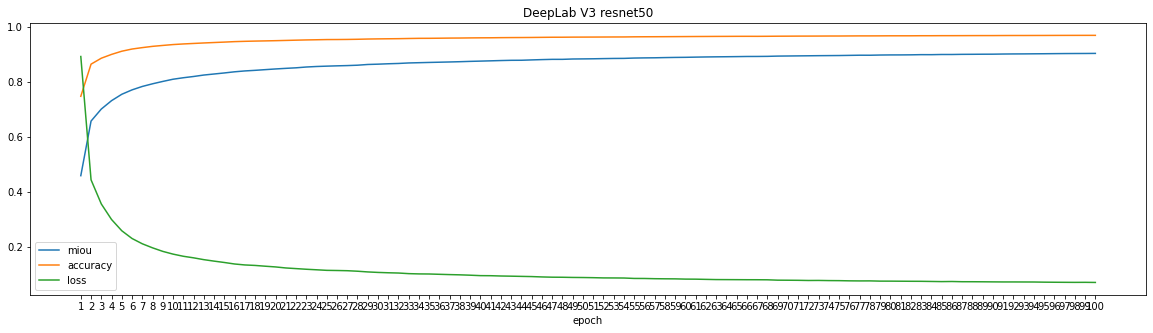

In [18]:
log_epoch = pd.read_csv('result/' + filename + '/train_log_epoch.csv', names = ['epoch', 'loss', 'accuracy', 'miou'])

plt.figure(figsize=(20, 5))
plt.plot(log_epoch['epoch'], log_epoch['miou'], label = 'miou')
plt.plot(log_epoch['epoch'], log_epoch['accuracy'], label = 'accuracy')
plt.plot(log_epoch['epoch'], log_epoch['loss'], label = 'loss')
plt.xticks([i for i in range(1, log_epoch.shape[0]+1)])
plt.title("DeepLab V3 resnet50")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

## validation

In [19]:
val_X = torch.tensor(val_x, dtype=torch.float32)
val_Y = torch.tensor(val_y, dtype=torch.long)

val_data = torch.utils.data.TensorDataset(val_X.permute(dims=(0, 3, 1, 2)), val_Y)

val_data = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)

In [20]:
# Load best model

save_path = os.getcwd() + '/result/' + filename + '/'
result = [file for file in sorted(os.listdir(save_path), reverse=False) if file[13:] == 'checkpoint.pth.tar' ]

In [22]:
len(result), result[0]

(100, '210606_14:26_checkpoint.pth.tar')

In [23]:
for i, file in enumerate(result):

    checkpoint = torch.load(save_path + file) 
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    print('Loaded best model weights (epoch {}) from {}'.format(checkpoint['epoch'], file))

    model.eval()

    loss_running = AverageMeter('Loss', ':.4e')
    acc_running = AverageMeter('Accuracy', ':.3f')
    iou = iouCalc(classLabels, validClasses, voidClass = 11)

    batch_loss = 0.0
    for batch, (x, y) in enumerate(tqdm(val_data, total=len(val_data))):

        x = x.to(device)
        y = y.to(device)

        # forward
        outputs = model(x)
        outputs = outputs['out']

        preds = torch.argmax(outputs, 1)

        # cross-entropy loss
        loss = criterion(outputs, y)

        # Statistics
        bs = x.size(0)
        loss = loss.item()
        loss_running.update(loss, bs)
        corrects = torch.sum((preds == y) & (y != 12))

        nvoid = int((y==12).sum())
        acc = corrects.double()/(bs*res-nvoid)
        acc_running.update(acc, bs)

        # Calculate IoU scores of current batch
        iou.evaluateBatch(preds, y)

    miou = iou.outputScores()


    with open(save_path + 'val_log_epoch.csv', 'a') as epoch_log:
        epoch_log.write('{}, {}, {:.5f}, {:.5f}, {:.5f}\n'.format(
                i+1, file, loss_running.avg, acc_running.avg, miou))

    print('validataion')
    print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))

  2%|▏         | 1/62 [00:00<00:07,  7.79it/s]

Loaded best model weights (epoch 1) from 210606_14:26_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.266
SignSymbol    : 0.463
Bicyclist     : 0.494
Pedestrian    : 0.369
Building      : 0.725
Fence         : 0.508
Pavement      : 0.750
Road          : 0.899
Car           : 0.673
Sky           : 0.848
Tree          : 0.754
---------------------
Mean IoU      : 0.614
---------------------
validataion
loss : 0.5019   acc : 0.8450   miou : 0.6135
Loaded best model weights (epoch 2) from 210606_14:30_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.377
SignSymbol    : 0.529
Bicyclist     : 0.592
Pedestrian    : 0.464
Building      : 0.830
Fence         : 0.595
Pavement      : 0.777
Road          : 0.914
Car           : 0.811
Sky           : 0.888
Tree          : 0.788
---------------------
Mean IoU      : 0.688
---------------------
validataion
loss : 0.3541   acc : 0.8841   miou : 0.6877
Loaded best model weights (epoch 3) from 210606_14:34_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.401
SignSymbol    : 0.553
Bicyclist     : 0.644
Pedestrian    : 0.564
Building      : 0.828
Fence         : 0.650
Pavement      : 0.783
Road          : 0.892
Car           : 0.727
Sky           : 0.900
Tree          : 0.811
---------------------
Mean IoU      : 0.705
---------------------
validataion
loss : 0.3074   acc : 0.8850   miou : 0.7048
Loaded best model weights (epoch 4) from 210606_14:38_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.374
SignSymbol    : 0.606
Bicyclist     : 0.694
Pedestrian    : 0.509
Building      : 0.839
Fence         : 0.715
Pavement      : 0.833
Road          : 0.938
Car           : 0.854
Sky           : 0.906
Tree          : 0.811
---------------------
Mean IoU      : 0.734
---------------------
validataion
loss : 0.2622   acc : 0.9019   miou : 0.7345
Loaded best model weights (epoch 5) from 210606_14:43_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.426
SignSymbol    : 0.661
Bicyclist     : 0.595
Pedestrian    : 0.580
Building      : 0.870
Fence         : 0.587
Pavement      : 0.824
Road          : 0.935
Car           : 0.873
Sky           : 0.913
Tree          : 0.826
---------------------
Mean IoU      : 0.735
---------------------
validataion
loss : 0.2514   acc : 0.9119   miou : 0.7355
Loaded best model weights (epoch 6) from 210606_14:47_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.370
SignSymbol    : 0.618
Bicyclist     : 0.678
Pedestrian    : 0.612
Building      : 0.847
Fence         : 0.776
Pavement      : 0.863
Road          : 0.954
Car           : 0.884
Sky           : 0.909
Tree          : 0.835
---------------------
Mean IoU      : 0.759
---------------------
validataion
loss : 0.2149   acc : 0.9145   miou : 0.7588
Loaded best model weights (epoch 7) from 210606_14:51_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.423
SignSymbol    : 0.715
Bicyclist     : 0.742
Pedestrian    : 0.660
Building      : 0.878
Fence         : 0.761
Pavement      : 0.872
Road          : 0.948
Car           : 0.893
Sky           : 0.908
Tree          : 0.847
---------------------
Mean IoU      : 0.786
---------------------
validataion
loss : 0.1987   acc : 0.9224   miou : 0.7861
Loaded best model weights (epoch 8) from 210606_14:55_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.445
SignSymbol    : 0.695
Bicyclist     : 0.753
Pedestrian    : 0.642
Building      : 0.885
Fence         : 0.776
Pavement      : 0.873
Road          : 0.955
Car           : 0.888
Sky           : 0.911
Tree          : 0.858
---------------------
Mean IoU      : 0.789
---------------------
validataion
loss : 0.1798   acc : 0.9278   miou : 0.7893
Loaded best model weights (epoch 9) from 210606_14:59_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.453
SignSymbol    : 0.723
Bicyclist     : 0.768
Pedestrian    : 0.681
Building      : 0.870
Fence         : 0.782
Pavement      : 0.881
Road          : 0.959
Car           : 0.897
Sky           : 0.914
Tree          : 0.857
---------------------
Mean IoU      : 0.799
---------------------
validataion
loss : 0.1779   acc : 0.9274   miou : 0.7986
Loaded best model weights (epoch 10) from 210606_15:03_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.461
SignSymbol    : 0.746
Bicyclist     : 0.722
Pedestrian    : 0.705
Building      : 0.895
Fence         : 0.809
Pavement      : 0.875
Road          : 0.959
Car           : 0.907
Sky           : 0.923
Tree          : 0.867
---------------------
Mean IoU      : 0.806
---------------------
validataion
loss : 0.1651   acc : 0.9346   miou : 0.8063
Loaded best model weights (epoch 11) from 210606_15:07_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.461
SignSymbol    : 0.741
Bicyclist     : 0.737
Pedestrian    : 0.675
Building      : 0.898
Fence         : 0.829
Pavement      : 0.893
Road          : 0.963
Car           : 0.902
Sky           : 0.922
Tree          : 0.870
---------------------
Mean IoU      : 0.808
---------------------
validataion
loss : 0.1592   acc : 0.9364   miou : 0.8082
Loaded best model weights (epoch 12) from 210606_15:11_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.508
SignSymbol    : 0.768
Bicyclist     : 0.781
Pedestrian    : 0.717
Building      : 0.905
Fence         : 0.829
Pavement      : 0.895
Road          : 0.966
Car           : 0.913
Sky           : 0.927
Tree          : 0.878
---------------------
Mean IoU      : 0.826
---------------------
validataion
loss : 0.1495   acc : 0.9415   miou : 0.8261
Loaded best model weights (epoch 13) from 210606_15:15_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.506
SignSymbol    : 0.731
Bicyclist     : 0.765
Pedestrian    : 0.703
Building      : 0.912
Fence         : 0.847
Pavement      : 0.900
Road          : 0.966
Car           : 0.919
Sky           : 0.914
Tree          : 0.873
---------------------
Mean IoU      : 0.821
---------------------
validataion
loss : 0.1436   acc : 0.9408   miou : 0.8215
Loaded best model weights (epoch 14) from 210606_15:20_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.531
SignSymbol    : 0.749
Bicyclist     : 0.772
Pedestrian    : 0.679
Building      : 0.914
Fence         : 0.844
Pavement      : 0.907
Road          : 0.970
Car           : 0.919
Sky           : 0.928
Tree          : 0.878
---------------------
Mean IoU      : 0.826
---------------------
validataion
loss : 0.1386   acc : 0.9445   miou : 0.8264
Loaded best model weights (epoch 15) from 210606_15:24_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.527
SignSymbol    : 0.751
Bicyclist     : 0.755
Pedestrian    : 0.722
Building      : 0.913
Fence         : 0.863
Pavement      : 0.903
Road          : 0.969
Car           : 0.921
Sky           : 0.927
Tree          : 0.885
---------------------
Mean IoU      : 0.831
---------------------
validataion
loss : 0.1350   acc : 0.9455   miou : 0.8305
Loaded best model weights (epoch 16) from 210606_15:28_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.536
SignSymbol    : 0.798
Bicyclist     : 0.809
Pedestrian    : 0.735
Building      : 0.926
Fence         : 0.851
Pavement      : 0.912
Road          : 0.971
Car           : 0.923
Sky           : 0.924
Tree          : 0.885
---------------------
Mean IoU      : 0.843
---------------------
validataion
loss : 0.1314   acc : 0.9488   miou : 0.8429
Loaded best model weights (epoch 17) from 210606_15:32_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.537
SignSymbol    : 0.755
Bicyclist     : 0.779
Pedestrian    : 0.712
Building      : 0.915
Fence         : 0.874
Pavement      : 0.916
Road          : 0.970
Car           : 0.915
Sky           : 0.928
Tree          : 0.887
---------------------
Mean IoU      : 0.835
---------------------
validataion
loss : 0.1288   acc : 0.9470   miou : 0.8353
Loaded best model weights (epoch 18) from 210606_15:36_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.533
SignSymbol    : 0.819
Bicyclist     : 0.810
Pedestrian    : 0.752
Building      : 0.925
Fence         : 0.845
Pavement      : 0.910
Road          : 0.970
Car           : 0.925
Sky           : 0.930
Tree          : 0.889
---------------------
Mean IoU      : 0.846
---------------------
validataion
loss : 0.1228   acc : 0.9496   miou : 0.8461
Loaded best model weights (epoch 19) from 210606_15:40_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.549
SignSymbol    : 0.826
Bicyclist     : 0.809
Pedestrian    : 0.728
Building      : 0.917
Fence         : 0.869
Pavement      : 0.908
Road          : 0.967
Car           : 0.923
Sky           : 0.932
Tree          : 0.890
---------------------
Mean IoU      : 0.847
---------------------
validataion
loss : 0.1239   acc : 0.9479   miou : 0.8470
Loaded best model weights (epoch 20) from 210606_15:44_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.554
SignSymbol    : 0.789
Bicyclist     : 0.791
Pedestrian    : 0.746
Building      : 0.925
Fence         : 0.867
Pavement      : 0.916
Road          : 0.971
Car           : 0.925
Sky           : 0.927
Tree          : 0.895
---------------------
Mean IoU      : 0.846
---------------------
validataion
loss : 0.1213   acc : 0.9509   miou : 0.8461
Loaded best model weights (epoch 21) from 210606_15:48_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.555
SignSymbol    : 0.792
Bicyclist     : 0.790
Pedestrian    : 0.744
Building      : 0.924
Fence         : 0.849
Pavement      : 0.910
Road          : 0.969
Car           : 0.928
Sky           : 0.931
Tree          : 0.892
---------------------
Mean IoU      : 0.844
---------------------
validataion
loss : 0.1194   acc : 0.9497   miou : 0.8440
Loaded best model weights (epoch 22) from 210606_15:52_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.555
SignSymbol    : 0.805
Bicyclist     : 0.816
Pedestrian    : 0.748
Building      : 0.926
Fence         : 0.868
Pavement      : 0.921
Road          : 0.973
Car           : 0.923
Sky           : 0.931
Tree          : 0.895
---------------------
Mean IoU      : 0.851
---------------------
validataion
loss : 0.1158   acc : 0.9519   miou : 0.8509
Loaded best model weights (epoch 23) from 210606_15:56_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.586
SignSymbol    : 0.812
Bicyclist     : 0.808
Pedestrian    : 0.729
Building      : 0.934
Fence         : 0.885
Pavement      : 0.909
Road          : 0.968
Car           : 0.927
Sky           : 0.930
Tree          : 0.902
---------------------
Mean IoU      : 0.854
---------------------
validataion
loss : 0.1143   acc : 0.9531   miou : 0.8536
Loaded best model weights (epoch 24) from 210606_16:01_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.572
SignSymbol    : 0.815
Bicyclist     : 0.808
Pedestrian    : 0.764
Building      : 0.935
Fence         : 0.887
Pavement      : 0.922
Road          : 0.972
Car           : 0.931
Sky           : 0.934
Tree          : 0.900
---------------------
Mean IoU      : 0.858
---------------------
validataion
loss : 0.1083   acc : 0.9548   miou : 0.8582
Loaded best model weights (epoch 25) from 210606_16:05_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.586
SignSymbol    : 0.831
Bicyclist     : 0.826
Pedestrian    : 0.753
Building      : 0.931
Fence         : 0.877
Pavement      : 0.923
Road          : 0.971
Car           : 0.925
Sky           : 0.930
Tree          : 0.898
---------------------
Mean IoU      : 0.859
---------------------
validataion
loss : 0.1105   acc : 0.9524   miou : 0.8591
Loaded best model weights (epoch 26) from 210606_16:09_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.588
SignSymbol    : 0.813
Bicyclist     : 0.810
Pedestrian    : 0.751
Building      : 0.936
Fence         : 0.898
Pavement      : 0.916
Road          : 0.970
Car           : 0.933
Sky           : 0.932
Tree          : 0.904
---------------------
Mean IoU      : 0.859
---------------------
validataion
loss : 0.1092   acc : 0.9553   miou : 0.8593
Loaded best model weights (epoch 27) from 210606_16:13_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.576
SignSymbol    : 0.836
Bicyclist     : 0.811
Pedestrian    : 0.765
Building      : 0.930
Fence         : 0.889
Pavement      : 0.908
Road          : 0.966
Car           : 0.930
Sky           : 0.922
Tree          : 0.902
---------------------
Mean IoU      : 0.858
---------------------
validataion
loss : 0.1133   acc : 0.9522   miou : 0.8576
Loaded best model weights (epoch 28) from 210606_16:17_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.595
SignSymbol    : 0.845
Bicyclist     : 0.818
Pedestrian    : 0.763
Building      : 0.932
Fence         : 0.885
Pavement      : 0.924
Road          : 0.974
Car           : 0.936
Sky           : 0.933
Tree          : 0.906
---------------------
Mean IoU      : 0.865
---------------------
validataion
loss : 0.1041   acc : 0.9556   miou : 0.8645
Loaded best model weights (epoch 29) from 210606_16:21_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.571
SignSymbol    : 0.835
Bicyclist     : 0.819
Pedestrian    : 0.753
Building      : 0.938
Fence         : 0.883
Pavement      : 0.921
Road          : 0.973
Car           : 0.937
Sky           : 0.929
Tree          : 0.902
---------------------
Mean IoU      : 0.860
---------------------
validataion
loss : 0.1035   acc : 0.9553   miou : 0.8599
Loaded best model weights (epoch 30) from 210606_16:25_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.578
SignSymbol    : 0.839
Bicyclist     : 0.840
Pedestrian    : 0.783
Building      : 0.937
Fence         : 0.878
Pavement      : 0.929
Road          : 0.976
Car           : 0.937
Sky           : 0.937
Tree          : 0.899
---------------------
Mean IoU      : 0.867
---------------------
validataion
loss : 0.1017   acc : 0.9570   miou : 0.8666
Loaded best model weights (epoch 31) from 210606_16:29_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.593
SignSymbol    : 0.806
Bicyclist     : 0.815
Pedestrian    : 0.741
Building      : 0.933
Fence         : 0.889
Pavement      : 0.919
Road          : 0.971
Car           : 0.934
Sky           : 0.933
Tree          : 0.909
---------------------
Mean IoU      : 0.858
---------------------
validataion
loss : 0.1022   acc : 0.9551   miou : 0.8584
Loaded best model weights (epoch 32) from 210606_16:33_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.578
SignSymbol    : 0.841
Bicyclist     : 0.827
Pedestrian    : 0.770
Building      : 0.938
Fence         : 0.896
Pavement      : 0.928
Road          : 0.975
Car           : 0.934
Sky           : 0.932
Tree          : 0.910
---------------------
Mean IoU      : 0.866
---------------------
validataion
loss : 0.0988   acc : 0.9574   miou : 0.8664
Loaded best model weights (epoch 33) from 210606_16:37_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.596
SignSymbol    : 0.835
Bicyclist     : 0.816
Pedestrian    : 0.762
Building      : 0.940
Fence         : 0.882
Pavement      : 0.926
Road          : 0.973
Car           : 0.934
Sky           : 0.932
Tree          : 0.911
---------------------
Mean IoU      : 0.864
---------------------
validataion
loss : 0.0984   acc : 0.9576   miou : 0.8642
Loaded best model weights (epoch 34) from 210606_16:42_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.591
SignSymbol    : 0.828
Bicyclist     : 0.830
Pedestrian    : 0.775
Building      : 0.943
Fence         : 0.902
Pavement      : 0.919
Road          : 0.969
Car           : 0.935
Sky           : 0.934
Tree          : 0.914
---------------------
Mean IoU      : 0.867
---------------------
validataion
loss : 0.0990   acc : 0.9575   miou : 0.8671
Loaded best model weights (epoch 35) from 210606_16:46_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.611
SignSymbol    : 0.831
Bicyclist     : 0.845
Pedestrian    : 0.786
Building      : 0.944
Fence         : 0.887
Pavement      : 0.928
Road          : 0.975
Car           : 0.941
Sky           : 0.930
Tree          : 0.908
---------------------
Mean IoU      : 0.871
---------------------
validataion
loss : 0.0962   acc : 0.9586   miou : 0.8714
Loaded best model weights (epoch 36) from 210606_16:50_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.594
SignSymbol    : 0.849
Bicyclist     : 0.841
Pedestrian    : 0.792
Building      : 0.945
Fence         : 0.898
Pavement      : 0.928
Road          : 0.974
Car           : 0.942
Sky           : 0.936
Tree          : 0.913
---------------------
Mean IoU      : 0.874
---------------------
validataion
loss : 0.0955   acc : 0.9602   miou : 0.8739
Loaded best model weights (epoch 37) from 210606_16:54_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.606
SignSymbol    : 0.830
Bicyclist     : 0.816
Pedestrian    : 0.766
Building      : 0.941
Fence         : 0.915
Pavement      : 0.930
Road          : 0.976
Car           : 0.941
Sky           : 0.931
Tree          : 0.914
---------------------
Mean IoU      : 0.870
---------------------
validataion
loss : 0.0948   acc : 0.9591   miou : 0.8696
Loaded best model weights (epoch 38) from 210606_16:58_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.617
SignSymbol    : 0.836
Bicyclist     : 0.838
Pedestrian    : 0.781
Building      : 0.945
Fence         : 0.899
Pavement      : 0.934
Road          : 0.977
Car           : 0.938
Sky           : 0.931
Tree          : 0.912
---------------------
Mean IoU      : 0.873
---------------------
validataion
loss : 0.0934   acc : 0.9597   miou : 0.8735
Loaded best model weights (epoch 39) from 210606_17:02_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.602
SignSymbol    : 0.850
Bicyclist     : 0.834
Pedestrian    : 0.775
Building      : 0.943
Fence         : 0.895
Pavement      : 0.931
Road          : 0.976
Car           : 0.940
Sky           : 0.938
Tree          : 0.918
---------------------
Mean IoU      : 0.873
---------------------
validataion
loss : 0.0903   acc : 0.9606   miou : 0.8729
Loaded best model weights (epoch 40) from 210606_17:06_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.612
SignSymbol    : 0.848
Bicyclist     : 0.833
Pedestrian    : 0.772
Building      : 0.947
Fence         : 0.900
Pavement      : 0.935
Road          : 0.975
Car           : 0.943
Sky           : 0.940
Tree          : 0.916
---------------------
Mean IoU      : 0.875
---------------------
validataion
loss : 0.0924   acc : 0.9613   miou : 0.8748
Loaded best model weights (epoch 41) from 210606_17:10_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.591
SignSymbol    : 0.856
Bicyclist     : 0.850
Pedestrian    : 0.798
Building      : 0.944
Fence         : 0.904
Pavement      : 0.934
Road          : 0.977
Car           : 0.945
Sky           : 0.938
Tree          : 0.919
---------------------
Mean IoU      : 0.878
---------------------
validataion
loss : 0.0902   acc : 0.9616   miou : 0.8780
Loaded best model weights (epoch 42) from 210606_17:14_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.612
SignSymbol    : 0.835
Bicyclist     : 0.834
Pedestrian    : 0.789
Building      : 0.948
Fence         : 0.913
Pavement      : 0.934
Road          : 0.976
Car           : 0.944
Sky           : 0.938
Tree          : 0.917
---------------------
Mean IoU      : 0.876
---------------------
validataion
loss : 0.0886   acc : 0.9619   miou : 0.8765
Loaded best model weights (epoch 43) from 210606_17:18_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.609
SignSymbol    : 0.848
Bicyclist     : 0.845
Pedestrian    : 0.790
Building      : 0.942
Fence         : 0.904
Pavement      : 0.931
Road          : 0.976
Car           : 0.942
Sky           : 0.941
Tree          : 0.918
---------------------
Mean IoU      : 0.877
---------------------
validataion
loss : 0.0890   acc : 0.9612   miou : 0.8767
Loaded best model weights (epoch 44) from 210606_17:23_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.629
SignSymbol    : 0.848
Bicyclist     : 0.839
Pedestrian    : 0.777
Building      : 0.948
Fence         : 0.894
Pavement      : 0.933
Road          : 0.976
Car           : 0.943
Sky           : 0.938
Tree          : 0.918
---------------------
Mean IoU      : 0.877
---------------------
validataion
loss : 0.0886   acc : 0.9618   miou : 0.8767
Loaded best model weights (epoch 45) from 210606_17:27_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.621
SignSymbol    : 0.850
Bicyclist     : 0.847
Pedestrian    : 0.793
Building      : 0.947
Fence         : 0.916
Pavement      : 0.939
Road          : 0.979
Car           : 0.943
Sky           : 0.936
Tree          : 0.922
---------------------
Mean IoU      : 0.881
---------------------
validataion
loss : 0.0859   acc : 0.9628   miou : 0.8811
Loaded best model weights (epoch 46) from 210606_17:31_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.609
SignSymbol    : 0.856
Bicyclist     : 0.838
Pedestrian    : 0.780
Building      : 0.948
Fence         : 0.907
Pavement      : 0.936
Road          : 0.978
Car           : 0.946
Sky           : 0.938
Tree          : 0.919
---------------------
Mean IoU      : 0.878
---------------------
validataion
loss : 0.0867   acc : 0.9627   miou : 0.8777
Loaded best model weights (epoch 47) from 210606_17:35_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.616
SignSymbol    : 0.854
Bicyclist     : 0.852
Pedestrian    : 0.805
Building      : 0.948
Fence         : 0.916
Pavement      : 0.937
Road          : 0.977
Car           : 0.947
Sky           : 0.937
Tree          : 0.923
---------------------
Mean IoU      : 0.883
---------------------
validataion
loss : 0.0860   acc : 0.9628   miou : 0.8828
Loaded best model weights (epoch 48) from 210606_17:39_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.630
SignSymbol    : 0.865
Bicyclist     : 0.856
Pedestrian    : 0.799
Building      : 0.952
Fence         : 0.921
Pavement      : 0.939
Road          : 0.979
Car           : 0.948
Sky           : 0.938
Tree          : 0.922
---------------------
Mean IoU      : 0.886
---------------------
validataion
loss : 0.0831   acc : 0.9644   miou : 0.8861
Loaded best model weights (epoch 49) from 210606_17:43_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.617
SignSymbol    : 0.860
Bicyclist     : 0.845
Pedestrian    : 0.794
Building      : 0.947
Fence         : 0.917
Pavement      : 0.939
Road          : 0.979
Car           : 0.945
Sky           : 0.941
Tree          : 0.926
---------------------
Mean IoU      : 0.883
---------------------
validataion
loss : 0.0839   acc : 0.9638   miou : 0.8826
Loaded best model weights (epoch 50) from 210606_17:47_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.630
SignSymbol    : 0.865
Bicyclist     : 0.857
Pedestrian    : 0.808
Building      : 0.952
Fence         : 0.913
Pavement      : 0.940
Road          : 0.980
Car           : 0.947
Sky           : 0.940
Tree          : 0.922
---------------------
Mean IoU      : 0.887
---------------------
validataion
loss : 0.0839   acc : 0.9648   miou : 0.8868
Loaded best model weights (epoch 51) from 210606_17:51_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.622
SignSymbol    : 0.856
Bicyclist     : 0.853
Pedestrian    : 0.799
Building      : 0.948
Fence         : 0.914
Pavement      : 0.941
Road          : 0.979
Car           : 0.946
Sky           : 0.941
Tree          : 0.924
---------------------
Mean IoU      : 0.884
---------------------
validataion
loss : 0.0815   acc : 0.9640   miou : 0.8840
Loaded best model weights (epoch 52) from 210606_17:55_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.630
SignSymbol    : 0.861
Bicyclist     : 0.876
Pedestrian    : 0.798
Building      : 0.946
Fence         : 0.915
Pavement      : 0.941
Road          : 0.981
Car           : 0.948
Sky           : 0.940
Tree          : 0.924
---------------------
Mean IoU      : 0.887
---------------------
validataion
loss : 0.0813   acc : 0.9640   miou : 0.8872
Loaded best model weights (epoch 53) from 210606_17:59_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.626
SignSymbol    : 0.861
Bicyclist     : 0.852
Pedestrian    : 0.794
Building      : 0.949
Fence         : 0.910
Pavement      : 0.938
Road          : 0.978
Car           : 0.949
Sky           : 0.937
Tree          : 0.923
---------------------
Mean IoU      : 0.883
---------------------
validataion
loss : 0.0811   acc : 0.9635   miou : 0.8834
Loaded best model weights (epoch 54) from 210606_18:04_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.633
SignSymbol    : 0.877
Bicyclist     : 0.862
Pedestrian    : 0.802
Building      : 0.953
Fence         : 0.920
Pavement      : 0.941
Road          : 0.979
Car           : 0.950
Sky           : 0.940
Tree          : 0.927
---------------------
Mean IoU      : 0.889
---------------------
validataion
loss : 0.0804   acc : 0.9659   miou : 0.8895
Loaded best model weights (epoch 55) from 210606_18:08_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.633
SignSymbol    : 0.857
Bicyclist     : 0.858
Pedestrian    : 0.810
Building      : 0.953
Fence         : 0.922
Pavement      : 0.941
Road          : 0.979
Car           : 0.947
Sky           : 0.940
Tree          : 0.927
---------------------
Mean IoU      : 0.888
---------------------
validataion
loss : 0.0797   acc : 0.9654   miou : 0.8879
Loaded best model weights (epoch 56) from 210606_18:12_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.628
SignSymbol    : 0.862
Bicyclist     : 0.854
Pedestrian    : 0.806
Building      : 0.952
Fence         : 0.929
Pavement      : 0.937
Road          : 0.977
Car           : 0.947
Sky           : 0.941
Tree          : 0.927
---------------------
Mean IoU      : 0.887
---------------------
validataion
loss : 0.0802   acc : 0.9650   miou : 0.8874
Loaded best model weights (epoch 57) from 210606_18:16_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.631
SignSymbol    : 0.850
Bicyclist     : 0.858
Pedestrian    : 0.817
Building      : 0.949
Fence         : 0.921
Pavement      : 0.942
Road          : 0.979
Car           : 0.950
Sky           : 0.939
Tree          : 0.924
---------------------
Mean IoU      : 0.887
---------------------
validataion
loss : 0.0795   acc : 0.9644   miou : 0.8872
Loaded best model weights (epoch 58) from 210606_18:20_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.632
SignSymbol    : 0.868
Bicyclist     : 0.849
Pedestrian    : 0.811
Building      : 0.951
Fence         : 0.924
Pavement      : 0.942
Road          : 0.979
Car           : 0.948
Sky           : 0.937
Tree          : 0.927
---------------------
Mean IoU      : 0.888
---------------------
validataion
loss : 0.0788   acc : 0.9651   miou : 0.8881
Loaded best model weights (epoch 59) from 210606_18:24_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.627
SignSymbol    : 0.872
Bicyclist     : 0.855
Pedestrian    : 0.806
Building      : 0.954
Fence         : 0.919
Pavement      : 0.940
Road          : 0.980
Car           : 0.952
Sky           : 0.942
Tree          : 0.928
---------------------
Mean IoU      : 0.889
---------------------
validataion
loss : 0.0783   acc : 0.9661   miou : 0.8886
Loaded best model weights (epoch 60) from 210606_18:28_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.639
SignSymbol    : 0.866
Bicyclist     : 0.860
Pedestrian    : 0.810
Building      : 0.955
Fence         : 0.926
Pavement      : 0.938
Road          : 0.976
Car           : 0.952
Sky           : 0.941
Tree          : 0.930
---------------------
Mean IoU      : 0.890
---------------------
validataion
loss : 0.0780   acc : 0.9657   miou : 0.8902
Loaded best model weights (epoch 61) from 210606_18:32_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.629
SignSymbol    : 0.871
Bicyclist     : 0.854
Pedestrian    : 0.813
Building      : 0.953
Fence         : 0.919
Pavement      : 0.942
Road          : 0.980
Car           : 0.948
Sky           : 0.940
Tree          : 0.927
---------------------
Mean IoU      : 0.889
---------------------
validataion
loss : 0.0789   acc : 0.9656   miou : 0.8888
Loaded best model weights (epoch 62) from 210606_18:36_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.648
SignSymbol    : 0.873
Bicyclist     : 0.858
Pedestrian    : 0.805
Building      : 0.953
Fence         : 0.929
Pavement      : 0.943
Road          : 0.981
Car           : 0.953
Sky           : 0.942
Tree          : 0.929
---------------------
Mean IoU      : 0.892
---------------------
validataion
loss : 0.0762   acc : 0.9669   miou : 0.8923
Loaded best model weights (epoch 63) from 210606_18:40_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.636
SignSymbol    : 0.873
Bicyclist     : 0.855
Pedestrian    : 0.808
Building      : 0.952
Fence         : 0.918
Pavement      : 0.945
Road          : 0.982
Car           : 0.951
Sky           : 0.940
Tree          : 0.929
---------------------
Mean IoU      : 0.890
---------------------
validataion
loss : 0.0761   acc : 0.9663   miou : 0.8899
Loaded best model weights (epoch 64) from 210606_18:45_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.652
SignSymbol    : 0.866
Bicyclist     : 0.859
Pedestrian    : 0.807
Building      : 0.954
Fence         : 0.918
Pavement      : 0.944
Road          : 0.979
Car           : 0.947
Sky           : 0.941
Tree          : 0.929
---------------------
Mean IoU      : 0.890
---------------------
validataion
loss : 0.0763   acc : 0.9661   miou : 0.8905
Loaded best model weights (epoch 65) from 210606_18:49_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.639
SignSymbol    : 0.869
Bicyclist     : 0.857
Pedestrian    : 0.813
Building      : 0.955
Fence         : 0.930
Pavement      : 0.943
Road          : 0.978
Car           : 0.950
Sky           : 0.937
Tree          : 0.931
---------------------
Mean IoU      : 0.891
---------------------
validataion
loss : 0.0763   acc : 0.9658   miou : 0.8912
Loaded best model weights (epoch 66) from 210606_18:53_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.625
SignSymbol    : 0.878
Bicyclist     : 0.868
Pedestrian    : 0.805
Building      : 0.952
Fence         : 0.929
Pavement      : 0.942
Road          : 0.979
Car           : 0.950
Sky           : 0.940
Tree          : 0.930
---------------------
Mean IoU      : 0.891
---------------------
validataion
loss : 0.0751   acc : 0.9655   miou : 0.8907
Loaded best model weights (epoch 67) from 210606_18:57_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.644
SignSymbol    : 0.875
Bicyclist     : 0.863
Pedestrian    : 0.805
Building      : 0.955
Fence         : 0.928
Pavement      : 0.945
Road          : 0.981
Car           : 0.953
Sky           : 0.937
Tree          : 0.930
---------------------
Mean IoU      : 0.892
---------------------
validataion
loss : 0.0753   acc : 0.9666   miou : 0.8923
Loaded best model weights (epoch 68) from 210606_19:01_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.654
SignSymbol    : 0.878
Bicyclist     : 0.866
Pedestrian    : 0.808
Building      : 0.957
Fence         : 0.923
Pavement      : 0.946
Road          : 0.981
Car           : 0.952
Sky           : 0.937
Tree          : 0.929
---------------------
Mean IoU      : 0.894
---------------------
validataion
loss : 0.0751   acc : 0.9672   miou : 0.8937
Loaded best model weights (epoch 69) from 210606_19:05_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.653
SignSymbol    : 0.878
Bicyclist     : 0.869
Pedestrian    : 0.813
Building      : 0.955
Fence         : 0.930
Pavement      : 0.949
Road          : 0.982
Car           : 0.952
Sky           : 0.939
Tree          : 0.930
---------------------
Mean IoU      : 0.896
---------------------
validataion
loss : 0.0741   acc : 0.9675   miou : 0.8955
Loaded best model weights (epoch 70) from 210606_19:09_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.644
SignSymbol    : 0.877
Bicyclist     : 0.864
Pedestrian    : 0.826
Building      : 0.955
Fence         : 0.931
Pavement      : 0.949
Road          : 0.982
Car           : 0.953
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.896
---------------------
validataion
loss : 0.0735   acc : 0.9675   miou : 0.8956
Loaded best model weights (epoch 71) from 210606_19:13_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.650
SignSymbol    : 0.866
Bicyclist     : 0.867
Pedestrian    : 0.803
Building      : 0.954
Fence         : 0.924
Pavement      : 0.948
Road          : 0.981
Car           : 0.951
Sky           : 0.941
Tree          : 0.932
---------------------
Mean IoU      : 0.893
---------------------
validataion
loss : 0.0729   acc : 0.9673   miou : 0.8925
Loaded best model weights (epoch 72) from 210606_19:17_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.660
SignSymbol    : 0.882
Bicyclist     : 0.865
Pedestrian    : 0.809
Building      : 0.958
Fence         : 0.920
Pavement      : 0.944
Road          : 0.979
Car           : 0.952
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.894
---------------------
validataion
loss : 0.0739   acc : 0.9673   miou : 0.8944
Loaded best model weights (epoch 73) from 210606_19:21_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.663
SignSymbol    : 0.884
Bicyclist     : 0.873
Pedestrian    : 0.814
Building      : 0.955
Fence         : 0.915
Pavement      : 0.947
Road          : 0.983
Car           : 0.957
Sky           : 0.941
Tree          : 0.933
---------------------
Mean IoU      : 0.897
---------------------
validataion
loss : 0.0748   acc : 0.9682   miou : 0.8968
Loaded best model weights (epoch 74) from 210606_19:26_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.649
SignSymbol    : 0.878
Bicyclist     : 0.871
Pedestrian    : 0.811
Building      : 0.958
Fence         : 0.942
Pavement      : 0.949
Road          : 0.981
Car           : 0.954
Sky           : 0.942
Tree          : 0.935
---------------------
Mean IoU      : 0.897
---------------------
validataion
loss : 0.0718   acc : 0.9686   miou : 0.8974
Loaded best model weights (epoch 75) from 210606_19:30_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.665
SignSymbol    : 0.890
Bicyclist     : 0.870
Pedestrian    : 0.822
Building      : 0.962
Fence         : 0.929
Pavement      : 0.946
Road          : 0.980
Car           : 0.956
Sky           : 0.941
Tree          : 0.933
---------------------
Mean IoU      : 0.899
---------------------
validataion
loss : 0.0736   acc : 0.9690   miou : 0.8994
Loaded best model weights (epoch 76) from 210606_19:34_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.661
SignSymbol    : 0.878
Bicyclist     : 0.875
Pedestrian    : 0.819
Building      : 0.960
Fence         : 0.930
Pavement      : 0.947
Road          : 0.981
Car           : 0.955
Sky           : 0.941
Tree          : 0.933
---------------------
Mean IoU      : 0.898
---------------------
validataion
loss : 0.0709   acc : 0.9687   miou : 0.8982
Loaded best model weights (epoch 77) from 210606_19:38_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.663
SignSymbol    : 0.877
Bicyclist     : 0.868
Pedestrian    : 0.826
Building      : 0.961
Fence         : 0.931
Pavement      : 0.949
Road          : 0.981
Car           : 0.955
Sky           : 0.942
Tree          : 0.932
---------------------
Mean IoU      : 0.899
---------------------
validataion
loss : 0.0712   acc : 0.9692   miou : 0.8986
Loaded best model weights (epoch 78) from 210606_19:42_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.653
SignSymbol    : 0.867
Bicyclist     : 0.878
Pedestrian    : 0.819
Building      : 0.956
Fence         : 0.930
Pavement      : 0.946
Road          : 0.980
Car           : 0.954
Sky           : 0.942
Tree          : 0.933
---------------------
Mean IoU      : 0.896
---------------------
validataion
loss : 0.0711   acc : 0.9677   miou : 0.8961
Loaded best model weights (epoch 79) from 210606_19:46_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.672
SignSymbol    : 0.886
Bicyclist     : 0.874
Pedestrian    : 0.830
Building      : 0.961
Fence         : 0.931
Pavement      : 0.951
Road          : 0.983
Car           : 0.957
Sky           : 0.942
Tree          : 0.935
---------------------
Mean IoU      : 0.902
---------------------
validataion
loss : 0.0705   acc : 0.9700   miou : 0.9021
Loaded best model weights (epoch 80) from 210606_19:50_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.660
SignSymbol    : 0.868
Bicyclist     : 0.870
Pedestrian    : 0.816
Building      : 0.955
Fence         : 0.935
Pavement      : 0.947
Road          : 0.982
Car           : 0.957
Sky           : 0.938
Tree          : 0.932
---------------------
Mean IoU      : 0.896
---------------------
validataion
loss : 0.0708   acc : 0.9677   miou : 0.8963
Loaded best model weights (epoch 81) from 210606_19:54_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.667
SignSymbol    : 0.875
Bicyclist     : 0.869
Pedestrian    : 0.817
Building      : 0.956
Fence         : 0.932
Pavement      : 0.950
Road          : 0.979
Car           : 0.953
Sky           : 0.941
Tree          : 0.933
---------------------
Mean IoU      : 0.897
---------------------
validataion
loss : 0.0706   acc : 0.9675   miou : 0.8973
Loaded best model weights (epoch 82) from 210606_19:58_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.657
SignSymbol    : 0.884
Bicyclist     : 0.881
Pedestrian    : 0.829
Building      : 0.960
Fence         : 0.931
Pavement      : 0.950
Road          : 0.982
Car           : 0.955
Sky           : 0.944
Tree          : 0.934
---------------------
Mean IoU      : 0.901
---------------------
validataion
loss : 0.0693   acc : 0.9695   miou : 0.9006
Loaded best model weights (epoch 83) from 210606_20:03_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.665
SignSymbol    : 0.885
Bicyclist     : 0.879
Pedestrian    : 0.813
Building      : 0.955
Fence         : 0.932
Pavement      : 0.952
Road          : 0.984
Car           : 0.955
Sky           : 0.939
Tree          : 0.932
---------------------
Mean IoU      : 0.899
---------------------
validataion
loss : 0.0693   acc : 0.9684   miou : 0.8991
Loaded best model weights (epoch 84) from 210606_20:07_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.663
SignSymbol    : 0.897
Bicyclist     : 0.870
Pedestrian    : 0.823
Building      : 0.962
Fence         : 0.931
Pavement      : 0.950
Road          : 0.981
Car           : 0.956
Sky           : 0.944
Tree          : 0.936
---------------------
Mean IoU      : 0.901
---------------------
validataion
loss : 0.0690   acc : 0.9699   miou : 0.9012
Loaded best model weights (epoch 85) from 210606_20:11_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.667
SignSymbol    : 0.878
Bicyclist     : 0.871
Pedestrian    : 0.829
Building      : 0.959
Fence         : 0.934
Pavement      : 0.950
Road          : 0.982
Car           : 0.957
Sky           : 0.944
Tree          : 0.934
---------------------
Mean IoU      : 0.900
---------------------
validataion
loss : 0.0690   acc : 0.9695   miou : 0.9005
Loaded best model weights (epoch 86) from 210606_20:15_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.658
SignSymbol    : 0.890
Bicyclist     : 0.867
Pedestrian    : 0.816
Building      : 0.958
Fence         : 0.935
Pavement      : 0.948
Road          : 0.982
Car           : 0.958
Sky           : 0.940
Tree          : 0.935
---------------------
Mean IoU      : 0.899
---------------------
validataion
loss : 0.0683   acc : 0.9688   miou : 0.8989
Loaded best model weights (epoch 87) from 210606_20:19_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.658
SignSymbol    : 0.890
Bicyclist     : 0.867
Pedestrian    : 0.812
Building      : 0.957
Fence         : 0.934
Pavement      : 0.951
Road          : 0.983
Car           : 0.958
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.899
---------------------
validataion
loss : 0.0684   acc : 0.9689   miou : 0.8986
Loaded best model weights (epoch 88) from 210606_20:23_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.670
SignSymbol    : 0.898
Bicyclist     : 0.878
Pedestrian    : 0.818
Building      : 0.960
Fence         : 0.937
Pavement      : 0.950
Road          : 0.982
Car           : 0.957
Sky           : 0.943
Tree          : 0.934
---------------------
Mean IoU      : 0.902
---------------------
validataion
loss : 0.0678   acc : 0.9695   miou : 0.9024
Loaded best model weights (epoch 89) from 210606_20:27_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.657
SignSymbol    : 0.882
Bicyclist     : 0.867
Pedestrian    : 0.829
Building      : 0.961
Fence         : 0.936
Pavement      : 0.948
Road          : 0.981
Car           : 0.957
Sky           : 0.942
Tree          : 0.936
---------------------
Mean IoU      : 0.900
---------------------
validataion
loss : 0.0681   acc : 0.9695   miou : 0.8997
Loaded best model weights (epoch 90) from 210606_20:31_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.672
SignSymbol    : 0.895
Bicyclist     : 0.883
Pedestrian    : 0.834
Building      : 0.962
Fence         : 0.935
Pavement      : 0.953
Road          : 0.984
Car           : 0.959
Sky           : 0.944
Tree          : 0.937
---------------------
Mean IoU      : 0.905
---------------------
validataion
loss : 0.0669   acc : 0.9709   miou : 0.9051
Loaded best model weights (epoch 91) from 210606_20:35_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.655
SignSymbol    : 0.884
Bicyclist     : 0.879
Pedestrian    : 0.824
Building      : 0.956
Fence         : 0.932
Pavement      : 0.952
Road          : 0.983
Car           : 0.958
Sky           : 0.943
Tree          : 0.936
---------------------
Mean IoU      : 0.900
---------------------
validataion
loss : 0.0676   acc : 0.9692   miou : 0.9001
Loaded best model weights (epoch 92) from 210606_20:39_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.666
SignSymbol    : 0.886
Bicyclist     : 0.880
Pedestrian    : 0.824
Building      : 0.960
Fence         : 0.936
Pavement      : 0.952
Road          : 0.983
Car           : 0.958
Sky           : 0.940
Tree          : 0.934
---------------------
Mean IoU      : 0.902
---------------------
validataion
loss : 0.0681   acc : 0.9697   miou : 0.9017
Loaded best model weights (epoch 93) from 210606_20:44_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.684
SignSymbol    : 0.887
Bicyclist     : 0.871
Pedestrian    : 0.819
Building      : 0.963
Fence         : 0.935
Pavement      : 0.947
Road          : 0.981
Car           : 0.957
Sky           : 0.942
Tree          : 0.937
---------------------
Mean IoU      : 0.902
---------------------
validataion
loss : 0.0680   acc : 0.9701   miou : 0.9021
Loaded best model weights (epoch 94) from 210606_20:48_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.670
SignSymbol    : 0.885
Bicyclist     : 0.874
Pedestrian    : 0.815
Building      : 0.963
Fence         : 0.938
Pavement      : 0.950
Road          : 0.981
Car           : 0.957
Sky           : 0.941
Tree          : 0.934
---------------------
Mean IoU      : 0.901
---------------------
validataion
loss : 0.0672   acc : 0.9694   miou : 0.9007
Loaded best model weights (epoch 95) from 210606_20:52_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.662
SignSymbol    : 0.894
Bicyclist     : 0.877
Pedestrian    : 0.824
Building      : 0.961
Fence         : 0.934
Pavement      : 0.955
Road          : 0.984
Car           : 0.960
Sky           : 0.943
Tree          : 0.938
---------------------
Mean IoU      : 0.903
---------------------
validataion
loss : 0.0663   acc : 0.9705   miou : 0.9028
Loaded best model weights (epoch 96) from 210606_20:56_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.672
SignSymbol    : 0.882
Bicyclist     : 0.873
Pedestrian    : 0.824
Building      : 0.961
Fence         : 0.941
Pavement      : 0.951
Road          : 0.983
Car           : 0.958
Sky           : 0.943
Tree          : 0.938
---------------------
Mean IoU      : 0.902
---------------------
validataion
loss : 0.0658   acc : 0.9705   miou : 0.9024
Loaded best model weights (epoch 97) from 210606_21:00_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.668
SignSymbol    : 0.886
Bicyclist     : 0.877
Pedestrian    : 0.836
Building      : 0.961
Fence         : 0.939
Pavement      : 0.953
Road          : 0.983
Car           : 0.958
Sky           : 0.943
Tree          : 0.938
---------------------
Mean IoU      : 0.904
---------------------
validataion
loss : 0.0658   acc : 0.9703   miou : 0.9039
Loaded best model weights (epoch 98) from 210606_21:04_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.676
SignSymbol    : 0.888
Bicyclist     : 0.873
Pedestrian    : 0.823
Building      : 0.959
Fence         : 0.938
Pavement      : 0.953
Road          : 0.982
Car           : 0.960
Sky           : 0.943
Tree          : 0.937
---------------------
Mean IoU      : 0.903
---------------------
validataion
loss : 0.0657   acc : 0.9701   miou : 0.9029
Loaded best model weights (epoch 99) from 210606_21:08_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.671
SignSymbol    : 0.879
Bicyclist     : 0.870
Pedestrian    : 0.831
Building      : 0.959
Fence         : 0.935
Pavement      : 0.948
Road          : 0.982
Car           : 0.960
Sky           : 0.941
Tree          : 0.936
---------------------
Mean IoU      : 0.901
---------------------
validataion
loss : 0.0658   acc : 0.9695   miou : 0.9010
Loaded best model weights (epoch 100) from 210606_21:12_checkpoint.pth.tar


100%|██████████| 62/62 [00:06<00:00,  9.24it/s]

classes           IoU
---------------------
Pole          : 0.669
SignSymbol    : 0.888
Bicyclist     : 0.879
Pedestrian    : 0.834
Building      : 0.962
Fence         : 0.933
Pavement      : 0.950
Road          : 0.982
Car           : 0.961
Sky           : 0.943
Tree          : 0.938
---------------------
Mean IoU      : 0.903
---------------------
validataion
loss : 0.0656   acc : 0.9703   miou : 0.9034


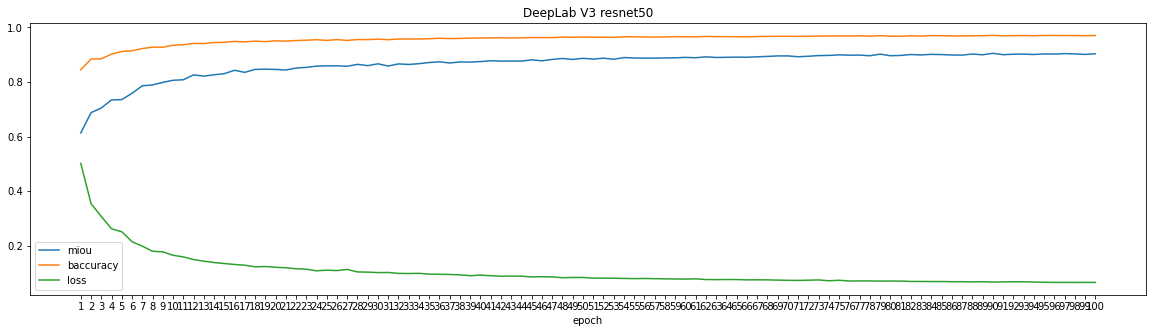

In [24]:
log_epoch = pd.read_csv('result/' + filename + '/val_log_epoch.csv', names = ['epoch', 'file_name', 'loss', 'accuracy', 'miou'])

plt.figure(figsize=(20, 5))
plt.plot(log_epoch['epoch'], log_epoch['miou'], label = 'miou')
plt.plot(log_epoch['epoch'], log_epoch['accuracy'], label = 'baccuracy')
plt.plot(log_epoch['epoch'], log_epoch['loss'], label = 'loss')
plt.xticks([i for i in range(1, log_epoch.shape[0]+1)])
plt.title("DeepLab V3 resnet50")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

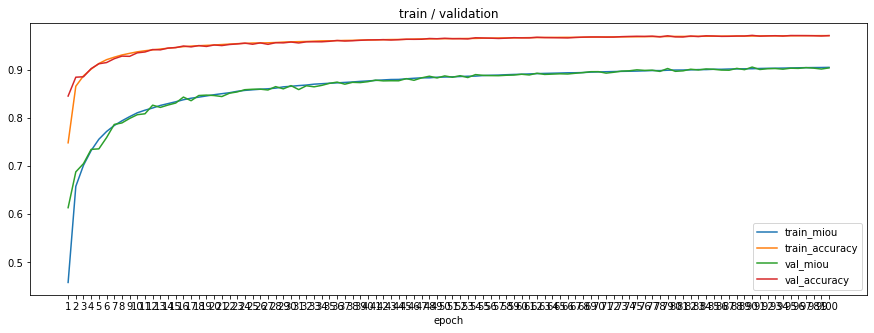

In [25]:
train_log_epoch = pd.read_csv('result/' + filename + '/train_log_epoch.csv', names = ['epoch', 'loss', 'accuracy', 'miou'])
val_log_epoch = pd.read_csv('result/' + filename + '/val_log_epoch.csv', names = ['epoch', 'file_name', 'loss', 'accuracy', 'miou'])

plt.figure(figsize=(15, 5))
plt.plot(train_log_epoch['epoch'], train_log_epoch['miou'], label = 'train_miou')
plt.plot(train_log_epoch['epoch'], train_log_epoch['accuracy'], label = 'train_accuracy')
plt.plot(val_log_epoch['epoch'], val_log_epoch['miou'], label = 'val_miou')
plt.plot(val_log_epoch['epoch'], val_log_epoch['accuracy'], label = 'val_accuracy')
plt.xticks([i for i in range(1, train_log_epoch.shape[0]+1)])
plt.title("train / validation")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

## test

In [26]:
X = torch.tensor(test_x, dtype=torch.float32)
Y = torch.tensor(test_y, dtype=torch.long)

data = torch.utils.data.TensorDataset(X.permute(dims=(0, 3, 1, 2)), Y)

test_data = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

In [27]:
# Load best model

save_path = os.getcwd() + '/result/' + filename + '/'
result = [file for file in sorted(os.listdir(save_path), reverse=True) if file[13:] == 'checkpoint.pth.tar' ]

In [28]:
bestmodel = result[0] # 최신모델

In [29]:
checkpoint = torch.load(save_path + bestmodel) # 가장 최신 best_weights 파일 가져옴
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('Loaded best model weights (epoch {}) from {}'.format(checkpoint['epoch'], filename + bestmodel))

Loaded best model weights (epoch 100) from 07_resnet_50210606_21:12_checkpoint.pth.tar


In [30]:
batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
loss_running = AverageMeter('Loss', ':.4e')
acc_running = AverageMeter('Accuracy', ':.3f')  
iou = iouCalc(classLabels, validClasses, voidClass = 11)
progress = ProgressMeter(
    len(test_data),
    [batch_time, data_time],
    prefix='Predict: ')

model.eval()

batch_loss = 0.0
for batch, (x, y) in enumerate(tqdm(test_data, total=len(test_data))):

    x = x.to(device)
    y = y.to(device)

    # forward
    outputs = model(x)
    outputs = outputs['out']

    preds = torch.argmax(outputs, 1)

    # cross-entropy loss
    loss = criterion(outputs, y)

    # Statistics
    bs = x.size(0)
    loss = loss.item()
    loss_running.update(loss, bs)
    corrects = torch.sum((preds == y) & (y != 12))

    nvoid = int((y==12).sum())
    acc = corrects.double()/(bs*res-nvoid)
    acc_running.update(acc, bs)

    # Calculate IoU scores of current batch
    iou.evaluateBatch(preds, y)

miou = iou.outputScores()
scheduler.step(loss_running.avg)

print('loss : {:.4f} acc : {:.4f} miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))

100%|██████████| 141/141 [00:14<00:00,  9.42it/s]

classes           IoU
---------------------
Pole          : 0.500
SignSymbol    : 0.647
Bicyclist     : 0.827
Pedestrian    : 0.711
Building      : 0.921
Fence         : 0.789
Pavement      : 0.859
Road          : 0.970
Car           : 0.907
Sky           : 0.931
Tree          : 0.847
---------------------
Mean IoU      : 0.810
---------------------
loss : 0.6262 acc : 0.9373 miou : 0.8099
